In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
from pathlib import Path
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

### US Weather Data Using NCEI API

In [2]:
import requests
import json

# List of station IDs
stations = [
    "USW00023050","USW00026451","USW00013874","USW00093784","USW00024033",
    "USW00024131","USW00014739","USW00094702","USW00014742","USW00013880",
    "USW00013866","USW00013881","USW00024018","USW00014819","USW00014821",
    "USW00014765","USW00013764","USW00023062","USW00014933","USW00014822",
    "USW00014914","USW00012918","USW00003856","USW00093819","USW00003940",
    "USW00013889","USW00003947","USW00023169","USW00003952","USW00023174",
    "USW00093821","USW00014710","USW00014839","USW00014922","USW00013897",
    "USW00012916","USW00094728","USW00014734","USW00013737","USW00013967",
    "USW00014942","USW00013739","USW00023183","USW00024229","USW00014764",
    "USW00024127","USW00024234","USW00014944","USW00013743","USW00003928",
    
]

# Join the station IDs into a string
stations_string = ','.join(stations)

# Example URL for NOAA's Climate Data Online (CDO) or other relevant endpoint
url = f"https://www.ncei.noaa.gov/access/services/data/v1?dataset=daily-summaries&stations={stations_string}&startDate=2018-01-01&endDate=2023-12-31&units=metric&format=json&includeStationName=true"


# Make the request
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Parse the JSON response
    data = response.json()

print(f"Number of entries: {len(data)}")
if data:  # Check if data is not empty
    first_date = data[0]['DATE']
    last_date = data[-1]['DATE']
    print(f"Date range: {first_date} to {last_date}")


Number of entries: 108719
Date range: 2018-01-01 to 2023-12-31


In [3]:
# Convert the data to a DataFrame
us_weather_df = pd.DataFrame(data)

# Display the first few rows of the DataFrame
us_weather_df.tail()


WSF2      STATION  WSF5 SNOW   RHMX    ASLP PRCP   RHAV SNWD  \
108714  10.7  USW00003928  13.4  0.0    NaN     NaN  0.0    NaN  0.0   
108715   9.4  USW00003928  12.5  0.0    NaN     NaN  0.0    NaN  0.0   
108716   9.4  USW00003928  12.5  0.0    NaN     NaN  0.0    NaN  0.0   
108717   4.5  USW00003928   6.3  0.0    NaN     NaN  0.0    NaN  0.0   
108718   9.4  USW00003928  12.1  0.0     89  1024.0  0.0     80  0.0   

                                                     NAME  ... SN52 PSUN TSUN  \
108714  WICHITA DWIGHT D. EISENHOWER NATIONAL AIRPORT,...  ...  NaN  NaN  NaN   
108715  WICHITA DWIGHT D. EISENHOWER NATIONAL AIRPORT,...  ...  NaN  NaN  NaN   
108716  WICHITA DWIGHT D. EISENHOWER NATIONAL AIRPORT,...  ...  NaN  NaN  NaN   
108717  WICHITA DWIGHT D. EISENHOWER NATIONAL AIRPORT,...  ...  NaN  NaN  NaN   
108718  WICHITA DWIGHT D. EISENHOWER NATIONAL AIRPORT,...  ...  NaN  NaN  NaN   

       TOBS WT11 MDSF DASF WDFG WSFG WESD  
108714  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
108715  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
108716  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
108717  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
108718  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[5 rows x 45 columns]

In [4]:
us_weather_df.columns

Index(['WSF2', 'STATION', 'WSF5', 'SNOW', 'RHMX', 'ASLP', 'PRCP', 'RHAV',
       'SNWD', 'NAME', 'ASTP', 'DATE', 'RHMN', 'WDF2', 'AWND', 'WDF5', 'AWBT',
       'TMAX', 'ADPT', 'TAVG', 'TMIN', 'WT08', 'WT01', 'PGTM', 'WT02', 'WT03',
       'WT05', 'WT09', 'WT07', 'WT06', 'WT04', 'WT10', 'SX32', 'SN32', 'SX52',
       'SN52', 'PSUN', 'TSUN', 'TOBS', 'WT11', 'MDSF', 'DASF', 'WDFG', 'WSFG',
       'WESD'],
      dtype='object')

In [5]:
us_weather_df['NAME'].unique()

array(['ALBUQUERQUE INTERNATIONAL AIRPORT, NM US',
       'ANCHORAGE TED STEVENS INTERNATIONAL AIRPORT, AK US',
       'ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPORT, GA US',
       'MARYLAND SCIENCE CENTER, MD US',
       'BILLINGS INTERNATIONAL AIRPORT, MT US',
       'BOISE AIR TERMINAL, ID US',
       'BOSTON LOGAN INTERNATIONAL AIRPORT, MA US',
       'IGOR I SIKORSKY MEMORIAL AIRPORT, CT US',
       'BURLINGTON INTERNATIONAL AIRPORT, VT US',
       'CHARLESTON INTL. AIRPORT, SC US',
       'CHARLESTON WEST VIRGINIA INTERNATIONAL YEAGER AIRPORT, WV US',
       'CHARLOTTE DOUGLAS AIRPORT, NC US', 'CHEYENNE WSFO AIRPORT, WY US',
       'CHICAGO MIDWAY AIRPORT, IL US',
       'JOHN GLENN INTERNATIONAL AIRPORT, OH US',
       'RHODE ISLAND T.F. GREEN INTERNATIONAL AIRPORT, RI US',
       'GEORGETOWN DELAWARE COASTAL AIRPORT, DE US',
       'DENVER CENTRAL PARK, CO US',
       'DES MOINES INTERNATIONAL AIRPORT, IA US',
       'DETROIT CITY AIRPORT, MI US',
       'FARGO HECTOR INTER

### Cleaning US weather data

In [6]:
#Checking data types
us_weather_df.dtypes

WSF2       object
STATION    object
WSF5       object
SNOW       object
RHMX       object
ASLP       object
PRCP       object
RHAV       object
SNWD       object
NAME       object
ASTP       object
DATE       object
RHMN       object
WDF2       object
AWND       object
WDF5       object
AWBT       object
TMAX       object
ADPT       object
TAVG       object
TMIN       object
WT08       object
WT01       object
PGTM       object
WT02       object
WT03       object
WT05       object
WT09       object
WT07       object
WT06       object
WT04       object
WT10       object
SX32       object
SN32       object
SX52       object
SN52       object
PSUN       object
TSUN       object
TOBS       object
WT11       object
MDSF       object
DASF       object
WDFG       object
WSFG       object
WESD       object
dtype: object

In [7]:
# Count the number of missing values (NaNs) in each column
missing_values_count = us_weather_df.isna().sum()

# Identify columns with more than 20,000 missing values
columns_to_drop = missing_values_count[missing_values_count > 20000].index

# Drop these columns from the DataFrame
us_weather_df.drop(columns=columns_to_drop, inplace=True)

In [8]:
# Setting data column as index
us_weather_df = us_weather_df.set_index('DATE')

In [9]:
# Dropping additional columns
additional_columns = ['WSF2', 'WSF5','RHMX','ASLP','RHAV','ASTP','RHMN','WDF2','WDF5','ADPT']
us_weather_df.drop(columns=additional_columns, inplace=True)

In [10]:
us_weather_df.dtypes

STATION    object
SNOW       object
PRCP       object
SNWD       object
NAME       object
AWND       object
AWBT       object
TMAX       object
TMIN       object
dtype: object

In [11]:
# Converting object columns to numeric types
columns_to_convert = ['SNOW', 'PRCP', 'SNWD', 'AWND', 'AWBT', 'TMAX', 'TMIN'] 

for column in columns_to_convert:
    us_weather_df[column] = pd.to_numeric(us_weather_df[column], errors='coerce')

# Checking types again
us_weather_df.dtypes

STATION     object
SNOW       float64
PRCP       float64
SNWD       float64
NAME        object
AWND       float64
AWBT       float64
TMAX       float64
TMIN       float64
dtype: object

In [12]:
us_weather_df.head()

STATION  SNOW  PRCP  SNWD  \
DATE                                        
2018-01-01  USW00023050   0.0   0.0   0.0   
2018-01-02  USW00023050   0.0   0.0   0.0   
2018-01-03  USW00023050   0.0   0.0   0.0   
2018-01-04  USW00023050   0.0   0.0   0.0   
2018-01-05  USW00023050   0.0   0.0   0.0   

                                                NAME  AWND  AWBT  TMAX  TMIN  
DATE                                                                          
2018-01-01  ALBUQUERQUE INTERNATIONAL AIRPORT, NM US   2.8  -4.4   8.9  -7.1  
2018-01-02  ALBUQUERQUE INTERNATIONAL AIRPORT, NM US   2.1  -2.2  12.8  -4.3  
2018-01-03  ALBUQUERQUE INTERNATIONAL AIRPORT, NM US   2.1  -3.3  10.0  -3.8  
2018-01-04  ALBUQUERQUE INTERNATIONAL AIRPORT, NM US   1.1  -2.8  11.1  -0.5  
2018-01-05  ALBUQUERQUE INTERNATIONAL AIRPORT, NM US   1.1  -2.8  12.8  -3.8

In [13]:
#making a copy
us_weather_copy = us_weather_df.copy()

In [14]:
us_weather_copy.isna().sum()

STATION        0
SNOW       16655
PRCP          50
SNWD       19366
NAME           0
AWND        4472
AWBT       15400
TMAX          37
TMIN          39
dtype: int64

In [15]:
# Handling missing values using interpolation
us_weather_copy['SNWD'].interpolate(method='linear', inplace=True)
us_weather_copy['PRCP'].interpolate(method='linear', inplace=True)
us_weather_copy['AWND'].interpolate(method='linear', inplace=True)
us_weather_copy['AWBT'].interpolate(method='linear', inplace=True)
us_weather_copy['TMAX'].interpolate(method='linear', inplace=True)
us_weather_copy['TMIN'].interpolate(method='linear', inplace=True)
us_weather_copy['SNOW'].interpolate(method='linear', inplace=True)

In [16]:
us_weather_copy.isna().sum()

STATION    0
SNOW       0
PRCP       0
SNWD       0
NAME       0
AWND       0
AWBT       0
TMAX       0
TMIN       0
dtype: int64

In [17]:
us_weather_copy.head()

STATION  SNOW  PRCP  SNWD  \
DATE                                        
2018-01-01  USW00023050   0.0   0.0   0.0   
2018-01-02  USW00023050   0.0   0.0   0.0   
2018-01-03  USW00023050   0.0   0.0   0.0   
2018-01-04  USW00023050   0.0   0.0   0.0   
2018-01-05  USW00023050   0.0   0.0   0.0   

                                                NAME  AWND  AWBT  TMAX  TMIN  
DATE                                                                          
2018-01-01  ALBUQUERQUE INTERNATIONAL AIRPORT, NM US   2.8  -4.4   8.9  -7.1  
2018-01-02  ALBUQUERQUE INTERNATIONAL AIRPORT, NM US   2.1  -2.2  12.8  -4.3  
2018-01-03  ALBUQUERQUE INTERNATIONAL AIRPORT, NM US   2.1  -3.3  10.0  -3.8  
2018-01-04  ALBUQUERQUE INTERNATIONAL AIRPORT, NM US   1.1  -2.8  11.1  -0.5  
2018-01-05  ALBUQUERQUE INTERNATIONAL AIRPORT, NM US   1.1  -2.8  12.8  -3.8

In [18]:
us_weather_copy.columns = us_weather_copy.columns.str.lower()

In [19]:
us_weather_copy.index.name = us_weather_copy.index.name.lower()

In [20]:
us_weather_copy.head()

station  snow  prcp  snwd  \
date                                        
2018-01-01  USW00023050   0.0   0.0   0.0   
2018-01-02  USW00023050   0.0   0.0   0.0   
2018-01-03  USW00023050   0.0   0.0   0.0   
2018-01-04  USW00023050   0.0   0.0   0.0   
2018-01-05  USW00023050   0.0   0.0   0.0   

                                                name  awnd  awbt  tmax  tmin  
date                                                                          
2018-01-01  ALBUQUERQUE INTERNATIONAL AIRPORT, NM US   2.8  -4.4   8.9  -7.1  
2018-01-02  ALBUQUERQUE INTERNATIONAL AIRPORT, NM US   2.1  -2.2  12.8  -4.3  
2018-01-03  ALBUQUERQUE INTERNATIONAL AIRPORT, NM US   2.1  -3.3  10.0  -3.8  
2018-01-04  ALBUQUERQUE INTERNATIONAL AIRPORT, NM US   1.1  -2.8  11.1  -0.5  
2018-01-05  ALBUQUERQUE INTERNATIONAL AIRPORT, NM US   1.1  -2.8  12.8  -3.8

In [21]:
# Dropping station column
us_weather_copy.drop(columns="station", inplace=True)

In [22]:
us_weather_copy['name'].unique()

array(['ALBUQUERQUE INTERNATIONAL AIRPORT, NM US',
       'ANCHORAGE TED STEVENS INTERNATIONAL AIRPORT, AK US',
       'ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPORT, GA US',
       'MARYLAND SCIENCE CENTER, MD US',
       'BILLINGS INTERNATIONAL AIRPORT, MT US',
       'BOISE AIR TERMINAL, ID US',
       'BOSTON LOGAN INTERNATIONAL AIRPORT, MA US',
       'IGOR I SIKORSKY MEMORIAL AIRPORT, CT US',
       'BURLINGTON INTERNATIONAL AIRPORT, VT US',
       'CHARLESTON INTL. AIRPORT, SC US',
       'CHARLESTON WEST VIRGINIA INTERNATIONAL YEAGER AIRPORT, WV US',
       'CHARLOTTE DOUGLAS AIRPORT, NC US', 'CHEYENNE WSFO AIRPORT, WY US',
       'CHICAGO MIDWAY AIRPORT, IL US',
       'JOHN GLENN INTERNATIONAL AIRPORT, OH US',
       'RHODE ISLAND T.F. GREEN INTERNATIONAL AIRPORT, RI US',
       'GEORGETOWN DELAWARE COASTAL AIRPORT, DE US',
       'DENVER CENTRAL PARK, CO US',
       'DES MOINES INTERNATIONAL AIRPORT, IA US',
       'DETROIT CITY AIRPORT, MI US',
       'FARGO HECTOR INTER

In [23]:
# Keep only the first word (the city name) in each entry of the "name" column
us_weather_copy['city'] = us_weather_copy['name'].str.split().str[0]

In [24]:
us_weather_copy.head()

snow  prcp  snwd                                      name  awnd  \
date                                                                           
2018-01-01   0.0   0.0   0.0  ALBUQUERQUE INTERNATIONAL AIRPORT, NM US   2.8   
2018-01-02   0.0   0.0   0.0  ALBUQUERQUE INTERNATIONAL AIRPORT, NM US   2.1   
2018-01-03   0.0   0.0   0.0  ALBUQUERQUE INTERNATIONAL AIRPORT, NM US   2.1   
2018-01-04   0.0   0.0   0.0  ALBUQUERQUE INTERNATIONAL AIRPORT, NM US   1.1   
2018-01-05   0.0   0.0   0.0  ALBUQUERQUE INTERNATIONAL AIRPORT, NM US   1.1   

            awbt  tmax  tmin         city  
date                                       
2018-01-01  -4.4   8.9  -7.1  ALBUQUERQUE  
2018-01-02  -2.2  12.8  -4.3  ALBUQUERQUE  
2018-01-03  -3.3  10.0  -3.8  ALBUQUERQUE  
2018-01-04  -2.8  11.1  -0.5  ALBUQUERQUE  
2018-01-05  -2.8  12.8  -3.8  ALBUQUERQUE

In [25]:
len(us_weather_copy)

108719

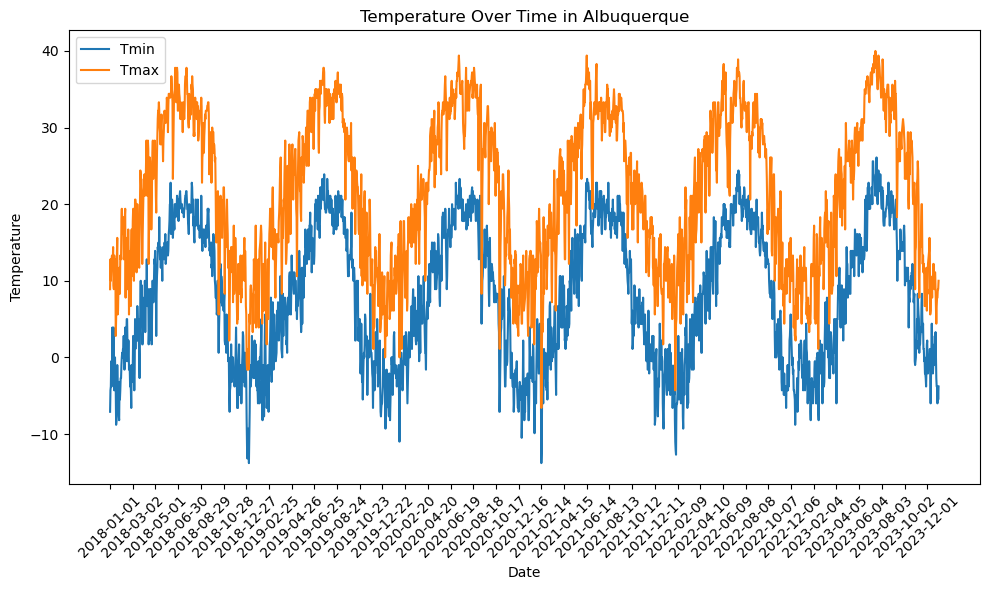

In [26]:
# plot
df_city = us_weather_copy[us_weather_copy['city'] == 'ALBUQUERQUE']

# Ensure the index is in datetime format for plotting
df_city.index = pd.to_datetime(df_city.index)

# Initialize the figure and its size before plotting
plt.figure(figsize=(10, 6))

# Now plot tmin and tmax
plt.plot(df_city.index, df_city['tmin'], label='Tmin')
plt.plot(df_city.index, df_city['tmax'], label='Tmax')

# Set the title, labels, and legend
plt.title('Temperature Over Time in Albuquerque')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()

# Since you're modifying the ticks, do this after the figure has been established
# Also, make sure to set the xticks before calling plt.show()
selected_ticks = df_city.index[::60]  # Every 60 days; adjust as needed
plt.xticks(selected_ticks, rotation=45)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


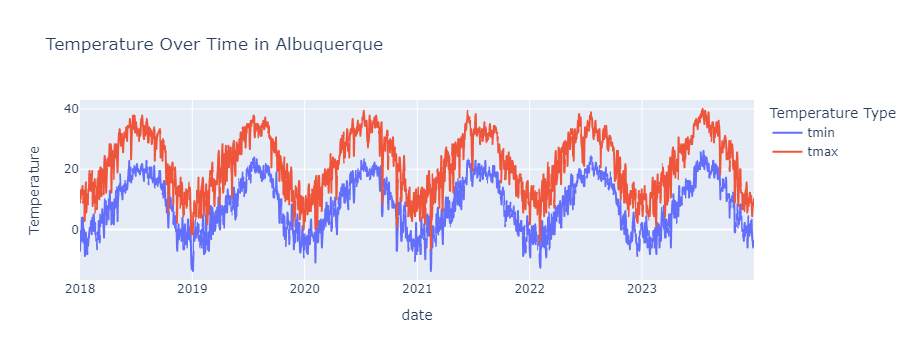

In [27]:
import plotly.express as px

fig = px.line(df_city, x=df_city.index, y=['tmin', 'tmax'], title='Temperature Over Time in Albuquerque', labels={'value': 'Temperature', 'variable': 'Temperature Type'})
fig.show()


In [72]:
# Create lagged temperature columns for 1-day, 3-day lags, and 7-day lags as "forecast"
us_weather_copy['temp_min_1d_lag'] = us_weather_copy['tmin'].shift(1)
us_weather_copy['temp_max_1d_lag'] = us_weather_copy['tmax'].shift(1)

us_weather_copy['temp_min_3d_lag'] = us_weather_copy['tmin'].shift(3)
us_weather_copy['temp_max_3d_lag'] = us_weather_copy['tmax'].shift(3)

us_weather_copy['temp_min_7d_lag'] = us_weather_copy['tmin'].shift(7)
us_weather_copy['temp_max_7d_lag'] = us_weather_copy['tmax'].shift(7)

### Canada Weather Data Using Openmeteo API

In [28]:
! pip install openmeteo-requests
! pip install requests-cache retry-requests numpy pandas

ERROR: Could not find a version that satisfies the requirement openmeteo-requests (from versions: none)
ERROR: No matching distribution found for openmeteo-requests


  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1


ERROR: holoviz 0.11.3 has requirement matplotlib==3.0.3, but you'll have matplotlib 3.1.3 which is incompatible.
ERROR: holoviz 0.11.3 has requirement pandas<=0.24.2,>=0.23.4, but you'll have pandas 1.3.5 which is incompatible.


In [29]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

In [30]:
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": [51.1762, 51.0501, 53.0168, 53.5501, 56.7268, 55.1667, 43.2501, 43.4254, 49.7, 42.9834, 50.0393, 45.5088, 45.4112, 46.8123, 52.2668, 43.7001, 49.2497, 49.8844],
    "longitude": [-115.5698, -114.0853, -112.8353, -113.4687, -111.381, -118.8027, -79.8496, -80.5112, -112.8186, -81.233, -110.6766, -73.5878, -75.6981, -71.2145, -113.802, -79.4163, -123.1193, -97.147],
    "start_date": "2018-01-01",
    "end_date": "2023-12-31",
    "daily": ["temperature_2m_max", "temperature_2m_min", "temperature_2m_mean", "precipitation_sum", "snowfall_sum", "wind_speed_10m_max"],
    "timezone": "auto"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
#response = responses[1]
all_cities_data = []

for city_index, response in enumerate(responses):

    daily = response.Daily()
    
    # Extracting daily data
    daily_temperature_2m_max = daily.Variables(0).ValuesAsNumpy()
    daily_temperature_2m_min = daily.Variables(1).ValuesAsNumpy()
    daily_temperature_2m_mean = daily.Variables(2).ValuesAsNumpy()
    daily_precipitation_sum = daily.Variables(3).ValuesAsNumpy()
    daily_snowfall_sum = daily.Variables(4).ValuesAsNumpy()
    daily_wind_speed_10m_max = daily.Variables(5).ValuesAsNumpy()
    
    # Getting the length of data (all arrays are of the same length and correspond to the same dates)
    num_days = len(daily_temperature_2m_max)
    
    for day_index in range(num_days):
        # Construct a record for each day
        day_data = {
            "city_index": city_index,
            "day_index": day_index,
            "temperature_2m_max": daily_temperature_2m_max[day_index],
            "temperature_2m_min": daily_temperature_2m_min[day_index],
            "temperature_2m_mean": daily_temperature_2m_mean[day_index],
            "precipitation_sum": daily_precipitation_sum[day_index],
            "snowfall_sum": daily_snowfall_sum[day_index],
            "wind_speed_10m_max": daily_wind_speed_10m_max[day_index]
        }
        
        # Append the day's data to the list
        all_cities_data.append(day_data)

# Convert the flattened list of dictionaries to a DataFrame
ca_weather_df = pd.DataFrame(all_cities_data)
    
#print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
#print(f"Elevation {response.Elevation()} m asl")
#print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
#print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

In [33]:
# List of city names ordered by their corresponding index
city_names = [
    "Banff", "Calgary", "Camrose", "Edmonton", "Fort_McMurray",
    "Grande_Prairie", "Hamilton", "Kitchener", "Lethbridge", "London",
    "Medicine_Hat", "Montreal", "Ottawa", "Quebec_City", "Red_Deer",
    "Toronto", "Vancouver", "Winnipeg"
]

# Replace each city_index with the corresponding city name from the 'city_names' list
ca_weather_df['city_name'] = ca_weather_df['city_index'].apply(lambda x: city_names[x])

# Drop the old column
ca_weather_df.drop('city_index', axis=1, inplace=True)


In [36]:
# Creating a date column
start_date = pd.to_datetime("2018-01-01")
end_date = pd.to_datetime("2023-12-31")
date_range = pd.date_range(start=start_date, end=end_date)
ca_weather_df['date'] = ca_weather_df['day_index'].apply(lambda x: date_range[x])

In [37]:
ca_weather_df.head()

day_index  temperature_2m_max  temperature_2m_min  temperature_2m_mean  \
0          0          -14.789001          -26.438999           -21.680666   
1          1           -5.789001          -20.889000           -14.270251   
2          2           -3.539000          -13.939000           -10.309834   
3          3           -3.389000          -13.289001            -9.414001   
4          4           -4.089000          -11.339000            -8.174417   

   precipitation_sum  snowfall_sum  wind_speed_10m_max city_name       date  
0                0.0           0.0            8.404284     Banff 2018-01-01  
1                0.0           0.0            7.342588     Banff 2018-01-02  
2                0.0           0.0            6.849467     Banff 2018-01-03  
3                0.0           0.0            7.208994     Banff 2018-01-04  
4                0.0           0.0            8.350138     Banff 2018-01-05

In [38]:
# Create a new copy and set 'date' column as index
ca_weather_copy = ca_weather_df.set_index('date')

In [40]:
# Drop the old column
ca_weather_copy.drop('day_index', axis=1, inplace=True)
ca_weather_copy.head()

temperature_2m_max  temperature_2m_min  temperature_2m_mean  \
date                                                                      
2018-01-01          -14.789001          -26.438999           -21.680666   
2018-01-02           -5.789001          -20.889000           -14.270251   
2018-01-03           -3.539000          -13.939000           -10.309834   
2018-01-04           -3.389000          -13.289001            -9.414001   
2018-01-05           -4.089000          -11.339000            -8.174417   

            precipitation_sum  snowfall_sum  wind_speed_10m_max city_name  
date                                                                       
2018-01-01                0.0           0.0            8.404284     Banff  
2018-01-02                0.0           0.0            7.342588     Banff  
2018-01-03                0.0           0.0            6.849467     Banff  
2018-01-04                0.0           0.0            7.208994     Banff  
2018-01-05                0.0           0.0            8.350138     Banff

In [53]:
len(ca_weather_copy)

39438

In [54]:
ca_weather_copy.index.unique()

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10',
               ...
               '2023-12-22', '2023-12-23', '2023-12-24', '2023-12-25',
               '2023-12-26', '2023-12-27', '2023-12-28', '2023-12-29',
               '2023-12-30', '2023-12-31'],
              dtype='datetime64[ns]', name='date', length=2191, freq=None)

In [55]:
us_weather_copy.index.unique()

Index(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',
       '2018-01-06', '2018-01-07', '2018-01-08', '2018-01-09', '2018-01-10',
       ...
       '2023-12-22', '2023-12-23', '2023-12-24', '2023-12-25', '2023-12-26',
       '2023-12-27', '2023-12-28', '2023-12-29', '2023-12-30', '2023-12-31'],
      dtype='object', name='date', length=2191)

In [49]:
ca_weather_copy.isnull().sum()

temperature_2m_max     0
temperature_2m_min     0
temperature_2m_mean    0
precipitation_sum      0
snowfall_sum           0
wind_speed_10m_max     0
city_name              0
dtype: int64

In [50]:
ca_city = ca_weather_copy[ca_weather_copy['city_name'] == 'Calgary']

# Ensure the index is in datetime format for plotting
ca_city.index = pd.to_datetime(ca_city.index)

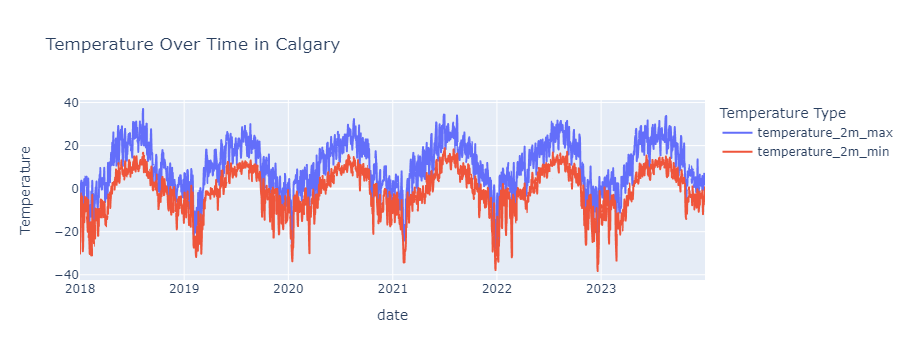

In [52]:
fig_ca = px.line(ca_city, x=ca_city.index, y=['temperature_2m_max', 'temperature_2m_min'], title='Temperature Over Time in Calgary', labels={'value': 'Temperature', 'variable': 'Temperature Type'})
fig_ca.show()

In [74]:
# Create lagged temperature columns for 1-day, 3-day lags, and 7-day lags as "forecast"
ca_weather_copy['temp_min_1d_lag'] = ca_weather_copy['temperature_2m_min'].shift(1)
ca_weather_copy['temp_max_1d_lag'] = ca_weather_copy['temperature_2m_max'].shift(1)

ca_weather_copy['temp_min_3d_lag'] = ca_weather_copy['temperature_2m_min'].shift(3)
ca_weather_copy['temp_max_3d_lag'] = ca_weather_copy['temperature_2m_max'].shift(3)

ca_weather_copy['temp_min_7d_lag'] = ca_weather_copy['temperature_2m_min'].shift(7)
ca_weather_copy['temp_max_7d_lag'] = ca_weather_copy['temperature_2m_max'].shift(7)

In [28]:
ca_weather_df = pd.read_csv("C:/Users/zhaoy/Documents/ECON_611_Uniper_Project/ECON-611-Uniper-Project/data_files/Monthly_data/CA_weather_data/combined_ca_weather.csv", encoding='ISO-8859-1')

In [29]:
ca_weather_df.head()

Station Name Date/Time  Year  Month  Day  Max Temp (°C)  Min Temp (°C)  \
0     BANFF CS  1/1/2017  2017      1    1           -8.2          -18.4   
1     BANFF CS  1/2/2017  2017      1    2          -17.3          -31.0   
2     BANFF CS  1/3/2017  2017      1    3          -19.3          -36.7   
3     BANFF CS  1/4/2017  2017      1    4          -15.2          -31.6   
4     BANFF CS  1/5/2017  2017      1    5          -10.2          -15.6   

   Mean Temp (°C)  Heat Deg Days (°C)  Cool Deg Days (°C)  Total Rain (mm)  \
0           -13.3                31.3                 0.0              NaN   
1           -24.2                42.2                 0.0              NaN   
2           -28.0                46.0                 0.0              NaN   
3           -23.4                41.4                 0.0              NaN   
4           -12.9                30.9                 0.0              NaN   

   Total Snow (cm)  Total Precip (mm)  Snow on Grnd (cm)  \
0              NaN                0.6               14.0   
1              NaN                3.3               14.0   
2              NaN                3.2               14.0   
3              NaN                0.3               13.0   
4              NaN                0.0               14.0   

   Dir of Max Gust (10s deg) Spd of Max Gust (km/h)  
0                        6.0                     37  
1                        NaN                    <31  
2                        NaN                    <31  
3                        NaN                    <31  
4                        NaN                    <31

In [30]:
ca_weather_df.dtypes

Station Name                  object
Date/Time                     object
Year                           int64
Month                          int64
Day                            int64
Max Temp (°C)                float64
Min Temp (°C)                float64
Mean Temp (°C)               float64
Heat Deg Days (°C)           float64
Cool Deg Days (°C)           float64
Total Rain (mm)              float64
Total Snow (cm)              float64
Total Precip (mm)            float64
Snow on Grnd (cm)            float64
Dir of Max Gust (10s deg)    float64
Spd of Max Gust (km/h)        object
dtype: object

In [31]:
ca_weather_df.isna().sum()

Station Name                     0
Date/Time                        0
Year                             0
Month                            0
Day                              0
Max Temp (°C)                 1904
Min Temp (°C)                 1894
Mean Temp (°C)                1962
Heat Deg Days (°C)            1962
Cool Deg Days (°C)            1962
Total Rain (mm)              25537
Total Snow (cm)              25488
Total Precip (mm)             5061
Snow on Grnd (cm)            33112
Dir of Max Gust (10s deg)    17977
Spd of Max Gust (km/h)       14462
dtype: int64

In [32]:
# making a copy
ca_weather_copy = ca_weather_df.copy()

In [33]:
# Changing date column name and convert it to datetime
ca_weather_copy.rename(columns={'Date/Time': 'Date'}, inplace=True)
ca_weather_copy = ca_weather_copy.set_index('Date')
ca_weather_copy.index = pd.to_datetime(ca_weather_copy.index)

In [34]:
# Change all letters to lower canse and add underscore in between words
ca_weather_copy.columns = ca_weather_copy.columns.str.lower()
ca_weather_copy.index.name = ca_weather_copy.index.name.lower()
ca_weather_copy.columns = ca_weather_copy.columns.str.replace(' ','_')

In [35]:
# Keep only the first word (the city name) in each entry of the "name" column
ca_weather_copy['city'] = ca_weather_copy['station_name'].str.split().str[0]

In [36]:
# Handling missing values using interpolation
numeric_cols = ca_weather_copy.select_dtypes(include=['float64', 'int64']).columns

for column in numeric_cols:
    ca_weather_copy[column].interpolate(method='linear', inplace=True)

In [37]:
ca_weather_copy.isnull().sum()

station_name                     0
year                             0
month                            0
day                              0
max_temp_(°c)                    0
min_temp_(°c)                    0
mean_temp_(°c)                   0
heat_deg_days_(°c)               0
cool_deg_days_(°c)               0
total_rain_(mm)               2556
total_snow_(cm)               2556
total_precip_(mm)                0
snow_on_grnd_(cm)                0
dir_of_max_gust_(10s_deg)        0
spd_of_max_gust_(km/h)       14462
city                             0
dtype: int64

In [38]:
# Using forward fill and backward fill to handle the rest of missing values
ca_weather_copy['total_rain_(mm)'].fillna(method='ffill', inplace=True)
ca_weather_copy['total_snow_(cm)'].fillna(method='ffill', inplace=True)
ca_weather_copy['spd_of_max_gust_(km/h)'].fillna(method='ffill', inplace=True)

ca_weather_copy['total_rain_(mm)'].fillna(method='bfill', inplace=True)
ca_weather_copy['total_snow_(cm)'].fillna(method='bfill', inplace=True)
ca_weather_copy['spd_of_max_gust_(km/h)'].fillna(method='bfill', inplace=True)

In [39]:
ca_weather_copy.isnull().sum()

station_name                 0
year                         0
month                        0
day                          0
max_temp_(°c)                0
min_temp_(°c)                0
mean_temp_(°c)               0
heat_deg_days_(°c)           0
cool_deg_days_(°c)           0
total_rain_(mm)              0
total_snow_(cm)              0
total_precip_(mm)            0
snow_on_grnd_(cm)            0
dir_of_max_gust_(10s_deg)    0
spd_of_max_gust_(km/h)       0
city                         0
dtype: int64

In [53]:
ca_weather_copy.city.unique()

array(['BANFF', 'CALGARY', 'CAMROSE', 'EDMONTON', 'FORT', 'GRANDE',
       'HAMILTON', 'KITCHENER/WATERLOO', 'LETHBRIDGE', 'LONDON',
       'MEDICINE', 'MONTREAL', 'OTTAWA', 'QUEBEC/JEAN', 'RED', 'TORONTO',
       'VANCOUVER', 'WINNIPEG'], dtype=object)

In [54]:
ca_city = ca_weather_copy[ca_weather_copy['city'] == 'CALGARY']

# Ensure the index is in datetime format for plotting
ca_city.index = pd.to_datetime(ca_city.index)

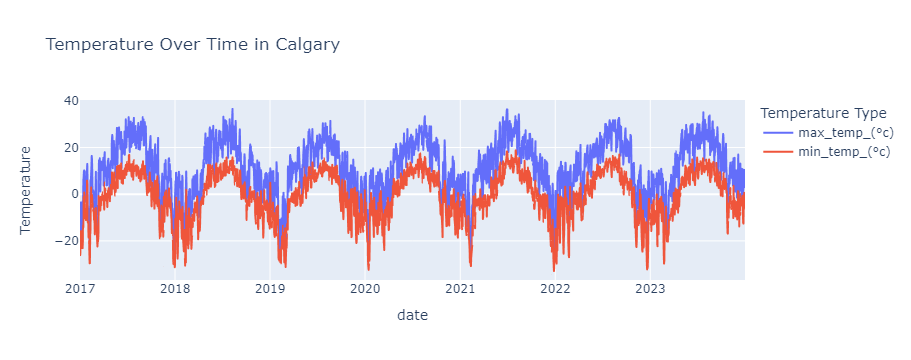

In [56]:
fig_ca = px.line(ca_city, x=ca_city.index, y=['max_temp_(°c)', 'min_temp_(°c)'], title='Temperature Over Time in Calgary', labels={'value': 'Temperature', 'variable': 'Temperature Type'})
fig_ca.show()

### Cleaning Alberta weather data

In [56]:
ab_weather_df = pd.read_csv("C:/Users/zhaoy/Documents/ECON_611_Uniper_Project/ECON-611-Uniper-Project/data_files/daily_data/CA_weather_data/alberta_weather.csv", encoding='ISO-8859-1')

In [57]:
ab_weather_df.head()

Township      Date  Air Temp. Min. (°C)  Air Temp. Max. (°C)  \
0  T009R21W4  1/1/2017               -14.94                -4.96   
1  T009R21W4  1/2/2017               -24.37               -13.47   
2  T009R21W4  1/3/2017               -29.41               -17.53   
3  T009R21W4  1/4/2017               -23.66               -10.17   
4  T009R21W4  1/5/2017               -20.93                -4.17   

   Precip. (mm)  Precip. Accumulated (mm)  Relative Humidity Avg. (%)  \
0          1.30                      1.30                       89.79   
1          0.27                      1.57                       85.18   
2          0.26                      1.83                       80.17   
3          0.27                      2.10                       81.87   
4          0.26                      2.36                       74.93   

   Modelled Snow Water Equiv. (mm)  Incoming Solar Rad. Total (MJ/m2)  \
0                            11.12                               3.13   
1                            11.42                               3.48   
2                            11.71                               4.48   
3                            12.01                               3.84   
4                            12.29                               3.49   

   Modelled Incoming Rad. Total (MJ/m2)  Wind Speed 10 m Avg. (km/h)  
0                                  3.99                        16.73  
1                                  4.20                         4.36  
2                                  4.41                         8.67  
3                                  4.74                        12.36  
4                                  5.33                        13.27

In [59]:
# Convert 'date' column to datetime format
ab_weather_df['Date'] = pd.to_datetime(ab_weather_df['Date'])

# Filter the DataFrame to keep observations on or after January 1, 2018
ab_weather_copy = ab_weather_df[ab_weather_df['Date'] >= '2018-01-01']

In [61]:
ab_weather_copy.isnull().sum()

Township                                  0
Date                                      0
Air Temp. Min. (°C)                       0
Air Temp. Max. (°C)                       0
Precip. (mm)                              0
Precip. Accumulated (mm)                  0
Relative Humidity Avg. (%)                0
Modelled Snow Water Equiv. (mm)           0
Incoming Solar Rad. Total (MJ/m2)       486
Modelled Incoming Rad. Total (MJ/m2)      0
Wind Speed 10 m Avg. (km/h)               0
dtype: int64

In [62]:
ab_weather_copy['Incoming Solar Rad. Total (MJ/m2)'].unique()

array([6.12, 5.73, 5.66, ..., 0.67, 7.52, 1.38])

In [63]:
# Handling missing values using interpolation
ab_weather_copy['Incoming Solar Rad. Total (MJ/m2)'].interpolate(method='linear', inplace=True)

C:\Users\zhaoy\anaconda3\envs\tf2\lib\site-packages\pandas\core\generic.py:6915: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [64]:
ab_weather_copy.isnull().sum()

Township                                0
Date                                    0
Air Temp. Min. (°C)                     0
Air Temp. Max. (°C)                     0
Precip. (mm)                            0
Precip. Accumulated (mm)                0
Relative Humidity Avg. (%)              0
Modelled Snow Water Equiv. (mm)         0
Incoming Solar Rad. Total (MJ/m2)       0
Modelled Incoming Rad. Total (MJ/m2)    0
Wind Speed 10 m Avg. (km/h)             0
dtype: int64

In [65]:
ab_weather_copy = ab_weather_copy.set_index('Date')
ab_weather_copy.index = pd.to_datetime(ab_weather_copy.index)

In [66]:
# Change all letters to lower canse and add underscore in between words
ab_weather_copy.columns = ab_weather_copy.columns.str.lower()
ab_weather_copy.index.name = ab_weather_copy.index.name.lower()
ab_weather_copy.columns = ab_weather_copy.columns.str.replace(' ','_')

In [67]:
ab_weather_copy.head()

township  air_temp._min._(°c)  air_temp._max._(°c)  precip._(mm)  \
date                                                                            
2018-01-01  T009R21W4               -36.27                -8.35           1.6   
2018-01-02  T009R21W4               -11.67                 0.57           1.0   
2018-01-03  T009R21W4                -8.32                 4.16           0.0   
2018-01-04  T009R21W4               -11.21                 1.60           0.0   
2018-01-05  T009R21W4                -7.62                 7.35           0.0   

            precip._accumulated_(mm)  relative_humidity_avg._(%)  \
date                                                               
2018-01-01                     277.3                       73.47   
2018-01-02                     278.3                       70.58   
2018-01-03                     278.3                       73.77   
2018-01-04                     278.3                       79.07   
2018-01-05                     278.3                       71.99   

            modelled_snow_water_equiv._(mm)  \
date                                          
2018-01-01                            24.56   
2018-01-02                            25.73   
2018-01-03                            25.69   
2018-01-04                            25.65   
2018-01-05                            25.60   

            incoming_solar_rad._total_(mj/m2)  \
date                                            
2018-01-01                               6.12   
2018-01-02                               5.73   
2018-01-03                               5.66   
2018-01-04                               5.97   
2018-01-05                               5.22   

            modelled_incoming_rad._total_(mj/m2)  wind_speed_10_m_avg._(km/h)  
date                                                                           
2018-01-01                                  6.67                        13.40  
2018-01-02                                  4.45                        15.22  
2018-01-03                                  4.53                        14.81  
2018-01-04                                  4.62                        12.68  
2018-01-05                                  5.04                        25.34

In [68]:
ab_city = ab_weather_copy[ab_weather_copy['township'] == 'T009R21W4']

# Ensure the index is in datetime format for plotting
ab_city.index = pd.to_datetime(ab_city.index)

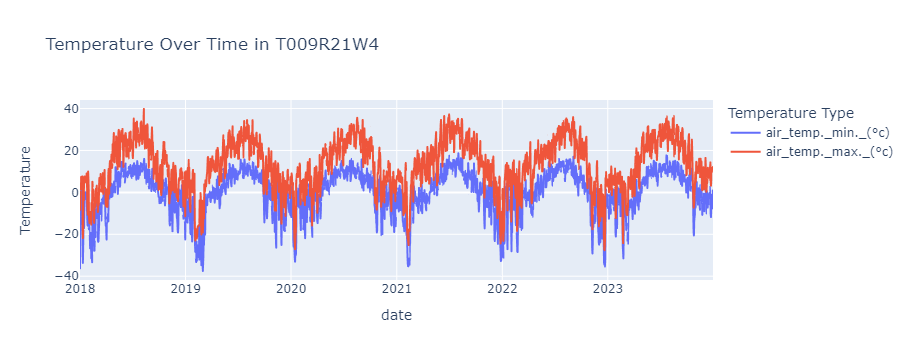

In [69]:
fig_ab = px.line(ab_city, x=ab_city.index, y=['air_temp._min._(°c)', 'air_temp._max._(°c)'], title='Temperature Over Time in T009R21W4', labels={'value': 'Temperature', 'variable': 'Temperature Type'})
fig_ab.show()

In [70]:
# Create lagged temperature columns for 1-day, 3-day lags, and 7-day lags as "forecast"
ab_weather_copy['temp_min_1d_lag'] = ab_weather_copy['air_temp._min._(°c)'].shift(1)
ab_weather_copy['temp_max_1d_lag'] = ab_weather_copy['air_temp._max._(°c)'].shift(1)

ab_weather_copy['temp_min_3d_lag'] = ab_weather_copy['air_temp._min._(°c)'].shift(3)
ab_weather_copy['temp_max_3d_lag'] = ab_weather_copy['air_temp._max._(°c)'].shift(3)

ab_weather_copy['temp_min_7d_lag'] = ab_weather_copy['air_temp._min._(°c)'].shift(7)
ab_weather_copy['temp_max_7d_lag'] = ab_weather_copy['air_temp._max._(°c)'].shift(7)

In [71]:
ab_weather_copy.head()

township  air_temp._min._(°c)  air_temp._max._(°c)  precip._(mm)  \
date                                                                            
2018-01-01  T009R21W4               -36.27                -8.35           1.6   
2018-01-02  T009R21W4               -11.67                 0.57           1.0   
2018-01-03  T009R21W4                -8.32                 4.16           0.0   
2018-01-04  T009R21W4               -11.21                 1.60           0.0   
2018-01-05  T009R21W4                -7.62                 7.35           0.0   

            precip._accumulated_(mm)  relative_humidity_avg._(%)  \
date                                                               
2018-01-01                     277.3                       73.47   
2018-01-02                     278.3                       70.58   
2018-01-03                     278.3                       73.77   
2018-01-04                     278.3                       79.07   
2018-01-05                     278.3                       71.99   

            modelled_snow_water_equiv._(mm)  \
date                                          
2018-01-01                            24.56   
2018-01-02                            25.73   
2018-01-03                            25.69   
2018-01-04                            25.65   
2018-01-05                            25.60   

            incoming_solar_rad._total_(mj/m2)  \
date                                            
2018-01-01                               6.12   
2018-01-02                               5.73   
2018-01-03                               5.66   
2018-01-04                               5.97   
2018-01-05                               5.22   

            modelled_incoming_rad._total_(mj/m2)  wind_speed_10_m_avg._(km/h)  \
date                                                                            
2018-01-01                                  6.67                        13.40   
2018-01-02                                  4.45                        15.22   
2018-01-03                                  4.53                        14.81   
2018-01-04                                  4.62                        12.68   
2018-01-05                                  5.04                        25.34   

            temp_min_1d_lag  temp_max_1d_lag  temp_min_3d_lag  \
date                                                            
2018-01-01              NaN              NaN              NaN   
2018-01-02           -36.27            -8.35              NaN   
2018-01-03           -11.67             0.57              NaN   
2018-01-04            -8.32             4.16           -36.27   
2018-01-05           -11.21             1.60           -11.67   

            temp_max_3d_lag  temp_min_7d_lag  temp_max_7d_lag  
date                                                           
2018-01-01              NaN              NaN              NaN  
2018-01-02              NaN              NaN              NaN  
2018-01-03              NaN              NaN              NaN  
2018-01-04            -8.35              NaN              NaN  
2018-01-05             0.57              NaN              NaN

### Load Cleaned Daily Prices for GAS and Other Daily Variables

In [76]:
price_variables_df = pd.read_csv("C:/Users/zhaoy/Documents/ECON_611_Uniper_Project/ECON-611-Uniper-Project/data_files/daily_data/Daily_data(cleaned).csv")

In [79]:
price_variables_df.tail()

date  henry_usd/mmbtu  aeco_5a_usd/mmbtu  aeco_5a_cad/gj  \
2155  2023-11-26            2.715             1.9322          2.5153   
2156  2023-11-27            2.715             1.8144          2.3449   
2157  2023-11-28            2.735             1.9060          2.4505   
2158  2023-11-29            2.785             1.8903          2.4360   
2159  2023-11-30            2.700             1.8949          2.4403   

      electricity_daily_average  electricity_daily_on_peak_average  \
2155                     106.34                             102.81   
2156                      49.04                              44.40   
2157                      51.51                              59.85   
2158                      62.49                              73.14   
2159                     266.94                             329.96   

      electricity_daily_off_peak_average  electricity_30ravg_average  \
2155                              113.40                       91.76   
2156                               58.32                       91.54   
2157                               34.84                       89.02   
2158                               41.19                       86.77   
2159                              140.90                       93.88   

      electricity_30ravg_on_peak_average  \
2155                              101.36   
2156                              101.35   
2157                               99.98   
2158                               96.45   
2159                              105.69   

      electricity_30ravg__off_peak_average  ...  \
2155                                 72.59  ...   
2156                                 71.95  ...   
2157                                 67.12  ...   
2158                                 67.42  ...   
2159                                 70.27  ...   

      ngtl_storage_receipts_volume_(103m3)  \
2155                                6569.5   
2156                                8955.5   
2157                               19439.8   
2158                               19277.6   
2159                               35370.5   

      ngtl_gordondale_receipts_volume_(103m3)  \
2155                                   3012.4   
2156                                   3018.1   
2157                                   3003.8   
2158                                   3034.2   
2159                                   3145.4   

      ngtl_groundbirch_east_receipts_volume_(103m3)  \
2155                                         2479.4   
2156                                         3398.0   
2157                                         5087.8   
2158                                         5073.7   
2159                                         3116.1   

      ngtl_intra_provincial_deliveries_volume_(103m3)  \
2155                                         198549.3   
2156                                         197237.6   
2157                                         191177.7   
2158                                         201121.4   
2159                                         205210.5   

      ngtl_border_deliveries_volume_(103m3)  \
2155                               215404.6   
2156                               212506.3   
2157                               238539.0   
2158                               240537.1   
2159                               238307.9   

      ngtl_empress_deliveries_volume_(103m3)  \
2155                                125546.6   
2156                                122333.4   
2157                                128295.2   
2158                                128294.9   
2159                                126615.2   

      ngtl_abc_deliveries_volume_(103m3)  \
2155                             62565.1   
2156                             62618.5   
2157                             81195.4   
2158                             81570.7   
2159                             82263.7   

      ngtl_mcneil_deliveries_volume_(103m3)  \
2155                   

In [92]:
# Create a new copy and set 'date' column as index
price_variables_copy = price_variables_df.set_index('date')

In [93]:
# Convert indexes to datetime
price_variables_copy.index = pd.to_datetime(price_variables_copy.index)

In [91]:
# Filter the DataFrame to keep observations before Nov 30, 2023
us_weather_copy = us_weather_copy[us_weather_copy.index <= '2023-11-30']
ca_weather_copy = ca_weather_copy[ca_weather_copy.index <= '2023-11-30']
ab_weather_copy = ab_weather_copy[ab_weather_copy.index <= '2023-11-30']

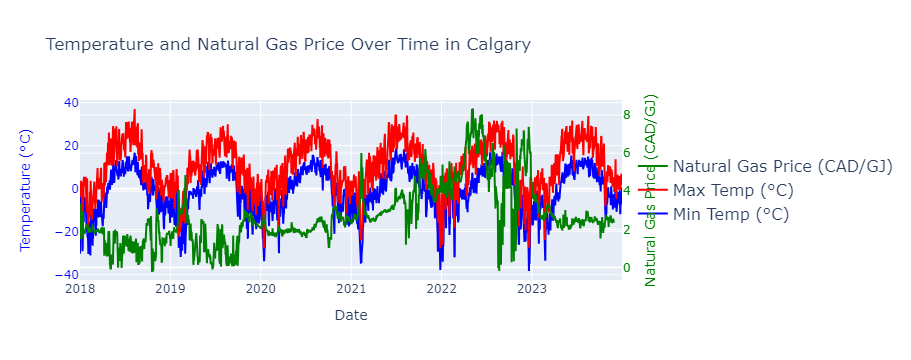

In [98]:
import plotly.graph_objects as go
# Create a Plotly figure
fig = go.Figure()

# Add temperature data
fig.add_trace(go.Scatter(x=ca_city.index, y=ca_city['temperature_2m_min'], name='Min Temp (°C)', mode='lines', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=ca_city.index, y=ca_city['temperature_2m_max'], name='Max Temp (°C)', mode='lines', line=dict(color='red')))

# Add natural gas price data using a secondary y-axis
fig.add_trace(go.Scatter(x=price_variables_copy.index, y=price_variables_copy['aeco_5a_cad/gj'], name='Natural Gas Price (CAD/GJ)', mode='lines', line=dict(color='green'), yaxis='y2'))

# Update layout with secondary y-axis
fig.update_layout(
    title='Temperature and Natural Gas Price Over Time in Calgary',
    xaxis_title='Date',
    yaxis_title='Temperature (°C)',
    yaxis=dict(
        title='Temperature (°C)',
        titlefont=dict(color='blue'),
        tickfont=dict(color='blue'),
    ),
    yaxis2=dict(
        title='Natural Gas Price (CAD/GJ)',
        titlefont=dict(color='green'),
        tickfont=dict(color='green'),
        overlaying='y',
        side='right'
    ),
    legend=dict(y=0.5, traceorder='reversed', font_size=16)
)

# Show the figure
fig.show()

### AECO Price Prediction

In [154]:
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

In [209]:
# Combine variables data with Calgary weather data
combined_df = pd.merge(price_variables_copy, ca_city, left_index=True, right_index=True, how='inner')

In [210]:
combined_df.head()

henry_usd/mmbtu  aeco_5a_usd/mmbtu  aeco_5a_cad/gj  \
date                                                             
2018-01-01            3.580             2.8248          3.3518   
2018-01-02            3.580             1.7509          2.0754   
2018-01-03            6.625             1.5555          1.8480   
2018-01-04            6.875             1.5478          1.8377   
2018-01-05            4.420             1.3134          1.5431   

            electricity_daily_average  electricity_daily_on_peak_average  \
date                                                                       
2018-01-01                      37.12                              35.50   
2018-01-02                      33.27                              33.89   
2018-01-03                      34.03                              35.20   
2018-01-04                      32.83                              34.77   
2018-01-05                      32.65                              34.10   

            electricity_daily_off_peak_average  electricity_30ravg_average  \
date                                                                         
2018-01-01                               40.36                       22.62   
2018-01-02                               32.05                       22.96   
2018-01-03                               31.69                       23.44   
2018-01-04                               28.93                       23.95   
2018-01-05                               29.76                       24.38   

            electricity_30ravg_on_peak_average  \
date                                             
2018-01-01                               23.69   
2018-01-02                               24.03   
2018-01-03                               24.53   
2018-01-04                               25.09   
2018-01-05                               25.53   

            electricity_30ravg__off_peak_average  \
date                                               
2018-01-01                                 20.48   
2018-01-02                                 20.82   
2018-01-03                                 21.25   
2018-01-04                                 21.67   
2018-01-05                                 22.06   

            measured_receipts_volume_(103m3)  ...  \
date                                          ...   
2018-01-01                          409984.7  ...   
2018-01-02                          417066.6  ...   
2018-01-03                          397375.6  ...   
2018-01-04                          410188.4  ...   
2018-01-05                          398015.6  ...   

            ngtl_gordondale_deliveries_volume_(103m3)  \
date                                                    
2018-01-01                                        0.0   
2018-01-02                                        0.0   
2018-01-03                                        0.0   
2018-01-04                                        0.0   
2018-01-05                                        0.0   

            ngtl_storage_deliveries_volume_(103m3)  aeco_return  \
date                                                              
2018-01-01                                     0.0          NaN   
2018-01-02                                   706.8    -0.380810   
2018-01-03                                   808.0    -0.109569   
2018-01-04                                   474.8    -0.005574   
2018-01-05                                   777.0    -0.160309   

            temperature_2m_max  temperature_2m_min  temperature_2m_mean  \
date                                                                      
2018-01-01              -3.751             -30.201           -16.969751   
2018-01-02              -0.101              -4.851            -3.138500   
2018-01-03               0.849              -4.201            -1.782250   
2018-01-04               1.299              -5.801            -3.728083   
2018-01-05               3.049              -6.001           

In [211]:
# Drop irrelavent columns
combined_df=combined_df.drop(['henry_usd/mmbtu','aeco_5a_usd/mmbtu','aeco_return','city_name'],axis=1)

In [212]:
combined_df.columns

Index(['aeco_5a_cad/gj', 'electricity_daily_average',
       'electricity_daily_on_peak_average',
       'electricity_daily_off_peak_average', 'electricity_30ravg_average',
       'electricity_30ravg_on_peak_average',
       'electricity_30ravg__off_peak_average',
       'measured_receipts_volume_(103m3)',
       'ngtl_storage_receipts_volume_(103m3)',
       'ngtl_gordondale_receipts_volume_(103m3)',
       'ngtl_groundbirch_east_receipts_volume_(103m3)',
       'ngtl_intra_provincial_deliveries_volume_(103m3)',
       'ngtl_border_deliveries_volume_(103m3)',
       'ngtl_empress_deliveries_volume_(103m3)',
       'ngtl_abc_deliveries_volume_(103m3)',
       'ngtl_mcneil_deliveries_volume_(103m3)',
       'ngtl_gordondale_deliveries_volume_(103m3)',
       'ngtl_storage_deliveries_volume_(103m3)', 'temperature_2m_max',
       'temperature_2m_min', 'temperature_2m_mean', 'precipitation_sum',
       'snowfall_sum', 'wind_speed_10m_max'],
      dtype='object')

### LR, Ridge, Lasso with Weather Variables Only

In [213]:
# Create a train/test split for the data using 2018-2022 for training and 2023 for testing
train = combined_df['2018':'2022']
test = combined_df['2023']

C:\Users\zhaoy\AppData\Local\Temp\ipykernel_17436\3448685978.py:3: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.



In [214]:
# Create train and test sets for dependent and independent variables
X_train1 = train[['temperature_2m_max','temperature_2m_min','temperature_2m_mean','precipitation_sum','snowfall_sum','wind_speed_10m_max']]
y_train = train[["aeco_5a_cad/gj"]]
X_test1 = test[['temperature_2m_max','temperature_2m_min','temperature_2m_mean','precipitation_sum','snowfall_sum','wind_speed_10m_max']]
y_test = test[["aeco_5a_cad/gj"]]

#### Linear Regression

In [230]:
# Create and fit model to the data, make predictions
model_lr1 = LinearRegression()
model_lr1.fit(X_train1, y_train)
predictions_lr1 = model_lr1.predict(X_test1)

In [234]:
# Construct a dataframe using just the "y" testing data
out_of_sample_results1 = y_test.copy()

# Rename the 'aeco_5a_cad/gj' column to 'Actual' for clarity
out_of_sample_results1.rename(columns={"aeco_5a_cad/gj": "Actual"}, inplace=True)

# Add a column of "out-of-sample" predictions to that dataframe
out_of_sample_results1["Out-of-Sample Predictions"] = predictions_lr1

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
      dtype=object)

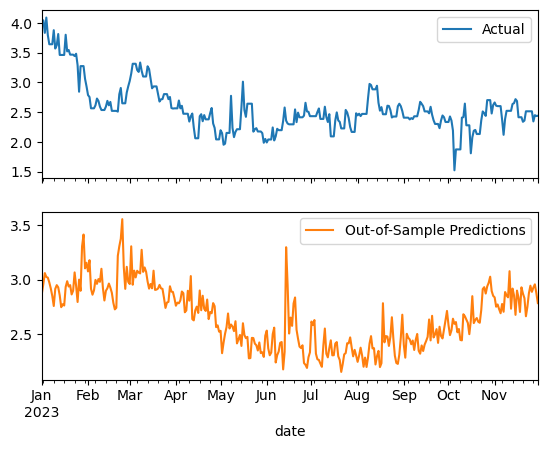

In [232]:
# Plot the out-of-sample results for 2023
out_of_sample_results1.plot(subplots=True)

In [238]:
# Evaluate the model
mse1 = mean_squared_error(y_test, predictions_lr1)
print("Mean Squared Error:", mse1)

# R squared
r_squared1 = model_lr1.score(X_test1, y_test)

print("R-squared for the model:", r_squared1)

Mean Squared Error: 0.14299197069460212
R-squared for the model: 0.1843689847255099


In [240]:
# Extract the coefficients
lr_coefficients1 = model_lr1.coef_
lr_coefficients1

array([[ 0.01231508, -0.00256354, -0.03728072,  0.01411822, -0.04326349,
         0.01825188]], dtype=float32)

#### Ridge

In [316]:
# Scale the features
scaler = StandardScaler()
X_train1_scaled = scaler.fit_transform(X_train1)
X_test1_scaled = scaler.transform(X_test1)

In [323]:
from sklearn.linear_model import RidgeCV

# Define a range of alpha values to test
alphas = np.logspace(-6, 6, 13)

# Create the RidgeCV instance with specified alphas and cross-validation strategy
model_ridge_cv = RidgeCV(alphas=alphas, cv=5) 

# Fit the model to the data
model_ridge_cv.fit(X_train1, y_train)

# Optimal alpha value
optimal_alpha_ridge = model_ridge_cv.alpha_
print("Optimal alpha (Ridge):", model_ridge_cv.alpha_)

Optimal alpha (Ridge): 100000.0


In [325]:
# Create and fit model to the data, make predictions
model_ridge1 = Ridge(alpha=optimal_alpha_ridge)
model_ridge1.fit(X_train1, y_train)
predictions_ridge1 = model_ridge1.predict(X_test1)

In [326]:
# Construct a dataframe using just the "y" testing data
out_of_sample_results2 = y_test.copy()

# Rename the 'aeco_5a_cad/gj' column to 'Actual' for clarity
out_of_sample_results2.rename(columns={"aeco_5a_cad/gj": "Actual"}, inplace=True)

# Add a column of "out-of-sample" predictions to that dataframe
out_of_sample_results2["Out-of-Sample Predictions"] = predictions_ridge1

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
      dtype=object)

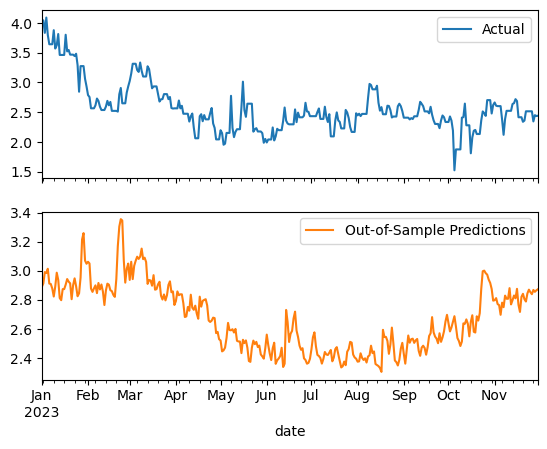

In [327]:
# Plot the out-of-sample results for 2023
out_of_sample_results2.plot(subplots=True)

In [328]:
# Evaluate the model
mse2 = mean_squared_error(y_test, predictions_ridge1)
print("Mean Squared Error:", mse2)

# R squared
r_squared2 = model_ridge1.score(X_test1, y_test)

print("R-squared for the model:", r_squared2)

Mean Squared Error: 0.13258553052895589
R-squared for the model: 0.2437276698073968


In [329]:
# Extract the coefficients
ridge_coefficients1 = model_ridge1.coef_
ridge_coefficients1

array([[-0.00700735, -0.00745356, -0.00746668,  0.00145189, -0.0003033 ,
         0.00660211]], dtype=float32)

#### LASSO

In [309]:
# Scale the features
scaler = StandardScaler()
X_train1_scaled = scaler.fit_transform(X_train1)
X_test1_scaled = scaler.transform(X_test1)

In [330]:
from sklearn.linear_model import LassoCV

# Create the LassoCV instance with specified alphas and cross-validation strategy
model_lasso_cv = LassoCV(cv=5, max_iter=10000, precompute=False)

# Fit the model to the data
model_lasso_cv.fit(X_train1, y_train.values.ravel())

# Optimal alpha value
optimal_alpha = model_lasso_cv.alpha_
print("Optimal alpha (Lasso):", optimal_alpha)

Optimal alpha (Lasso): 0.8503521806025465


In [331]:
# Create and fit the Lasso regression model to the data, make predictions
model_lasso1 = Lasso(alpha=optimal_alpha)
model_lasso1.fit(X_train1, y_train)
predictions_lasso1 = model_lasso1.predict(X_test1)

In [332]:
# Construct a dataframe using just the "y" testing data
out_of_sample_results3 = y_test.copy()

# Rename the 'aeco_5a_cad/gj' column to 'Actual' for clarity
out_of_sample_results3.rename(columns={"aeco_5a_cad/gj": "Actual"}, inplace=True)

# Add a column of "out-of-sample" predictions to that dataframe
out_of_sample_results3["Out-of-Sample Predictions"] = predictions_lasso1


array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
      dtype=object)

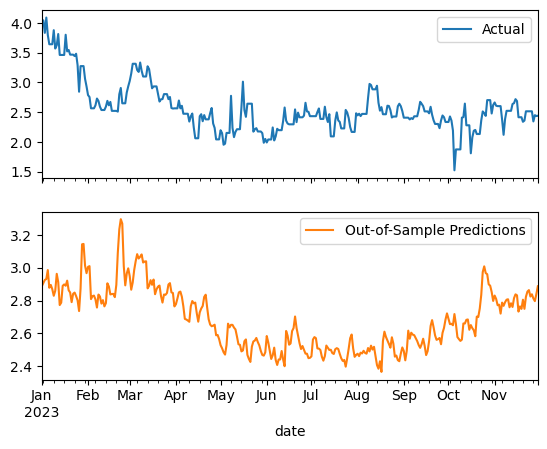

In [333]:
# Plot the out-of-sample results for 2023
out_of_sample_results3.plot(subplots=True)

In [334]:
# Evaluate the model
mse3 = mean_squared_error(y_test, predictions_lasso1)
print("Mean Squared Error:", mse3)

# R squared
r_squared3 = model_lasso1.score(X_test1, y_test)

print("R-squared for the model:", r_squared3)

Mean Squared Error: 0.1368266390235944
R-squared for the model: 0.2195362441590344


In [335]:
# Extract the coefficients
lasso_coefficients1 = model_lasso1.coef_
lasso_coefficients1

array([-0.00237732, -0.        , -0.01551303,  0.        , -0.        ,
        0.        ], dtype=float32)

In [341]:
# Convert coefficients lists to strings for display
lr_coefficients_str = ', '.join(map(str, lr_coefficients1))
ridge_coefficients_str = ', '.join(map(str, ridge_coefficients1))
lasso_coefficients_str = ', '.join(map(str, lasso_coefficients1))

# Create a DataFrame to display the comparison
comparison_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge', 'Lasso'],
    'MSE': [mse1, mse2, mse3],
    'R-Squared': [r_squared1, r_squared2, r_squared3],
    'Coefficients': [lr_coefficients_str, ridge_coefficients_str, lasso_coefficients_str]
})

pd.set_option('display.max_colwidth', None)
comparison_df

Model       MSE  R-Squared  \
0  Linear Regression  0.142992   0.184369   
1              Ridge  0.132586   0.243728   
2              Lasso  0.136827   0.219536   

                                                                Coefficients  
0  [ 0.01231508 -0.00256354 -0.03728072  0.01411822 -0.04326349  0.01825188]  
1  [-0.00700735 -0.00745356 -0.00746668  0.00145189 -0.0003033   0.00660211]  
2                          -0.0023773185, -0.0, -0.015513029, 0.0, -0.0, 0.0

### LR, Ridge, Lasso with All Variables

In [342]:
# Selecting features for X excluding the target variable 'aeco_5a_cad/gj'
X_features = combined_df.columns.difference(['aeco_5a_cad/gj']).tolist()

# Assigning the variables to X_train2 and X_test2 by selecting all columns except the target
X_train2 = train[X_features]
X_test2 = test[X_features]

# Keeping y_train and y_test assignments the same since the target variable remains unchanged
y_train = train[["aeco_5a_cad/gj"]]
y_test = test[["aeco_5a_cad/gj"]]


#### Linear Regression

In [356]:
# Create and fit model to the data, make predictions
model_lr2 = LinearRegression()
model_lr2.fit(X_train2, y_train)
predictions_lr2 = model_lr2.predict(X_test2)

In [357]:
# Construct a dataframe using just the "y" testing data
out_of_sample_results4 = y_test.copy()

# Rename the 'aeco_5a_cad/gj' column to 'Actual' for clarity
out_of_sample_results4.rename(columns={"aeco_5a_cad/gj": "Actual"}, inplace=True)

# Add a column of "out-of-sample" predictions to that dataframe
out_of_sample_results4["Out-of-Sample Predictions"] = predictions_lr2

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
      dtype=object)

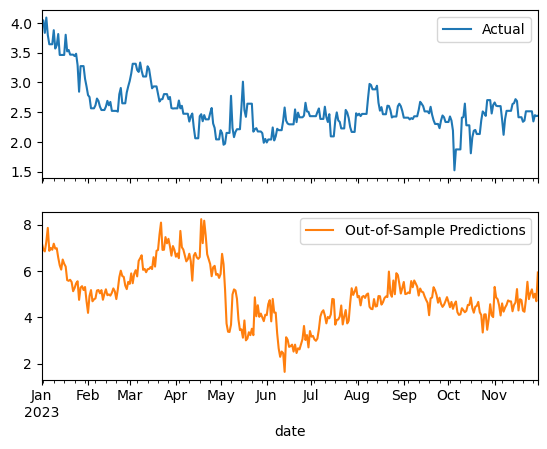

In [358]:
# Plot the out-of-sample results for 2023
out_of_sample_results4.plot(subplots=True)

In [359]:
# Evaluate the model
mse4 = mean_squared_error(y_test, predictions_lr2)
print("Mean Squared Error:", mse4)

# R squared
r_squared4 = model_lr2.score(X_test2, y_test)

print("R-squared for the model:", r_squared4)

Mean Squared Error: 6.998613419756329
R-squared for the model: -38.92032658435842


In [362]:
# Extract the coefficients
lr_coefficients2 = model_lr2.coef_
lr_coefficients2

array([[ 3.30614849e-01, -8.98044204e-01,  5.88550645e-01,
         1.43328203e-01, -4.46760515e-02, -9.39443825e-02,
         3.49183764e-05,  3.52326662e-05, -3.88953855e-05,
         4.86228947e-05, -1.03884858e-04, -1.22747149e-04,
        -6.80513496e-05, -3.24249004e-05,  6.25821223e-06,
         2.98096165e-05, -2.74087757e-06,  2.39729446e-02,
        -4.16338762e-03, -1.02013785e-02,  6.15077868e-04,
         1.12923612e-03,  2.98283154e-03]])

#### Ridge

In [348]:
# Scale the features
X_train2_scaled = scaler.fit_transform(X_train2)
X_test2_scaled = scaler.transform(X_test2)

In [385]:
# Define a range of alpha values to test
alphas = np.logspace(-6, 6, 13)

# Create the RidgeCV instance with specified alphas and cross-validation strategy
model_ridge_cv2 = RidgeCV(alphas=alphas, cv=5) 

# Fit the model to the data
model_ridge_cv2.fit(X_train2_scaled, y_train)

# Optimal alpha value
optimal_alpha_ridge2 = model_ridge_cv2.alpha_
print("Optimal alpha (Ridge):", model_ridge_cv2.alpha_)

Optimal alpha (Ridge): 1000.0


In [386]:
# Create and fit model to the data, make predictions
model_ridge2 = Ridge(alpha=optimal_alpha_ridge2)
model_ridge2.fit(X_train2_scaled, y_train)
predictions_ridge2 = model_ridge2.predict(X_test2_scaled)

In [387]:
# Construct a dataframe using just the "y" testing data
out_of_sample_results5 = y_test.copy()

# Rename the 'aeco_5a_cad/gj' column to 'Actual' for clarity
out_of_sample_results5.rename(columns={"aeco_5a_cad/gj": "Actual"}, inplace=True)

# Add a column of "out-of-sample" predictions to that dataframe
out_of_sample_results5["Out-of-Sample Predictions"] = predictions_ridge2

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
      dtype=object)

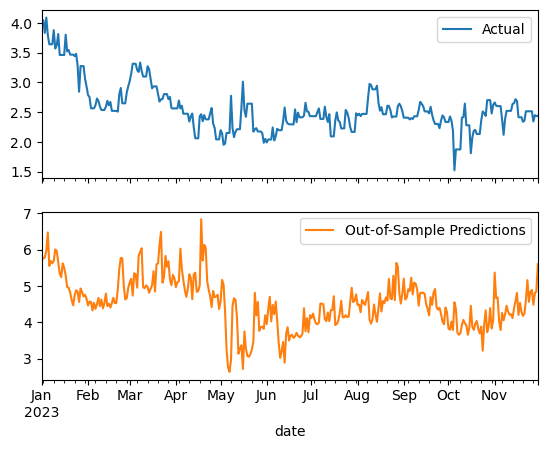

In [388]:
# Plot the out-of-sample results for 2023
out_of_sample_results5.plot(subplots=True)

In [389]:
# Evaluate the model
mse5 = mean_squared_error(y_test, predictions_ridge2)
print("Mean Squared Error:", mse5)

# R squared
r_squared5 = model_ridge2.score(X_test2_scaled, y_test)

print("R-squared for the model:", r_squared5)

Mean Squared Error: 4.2696519553520265
R-squared for the model: -23.354238509309155


In [390]:
# Extract the coefficients
ridge_coefficients2 = model_ridge2.coef_
ridge_coefficients2

array([[ 0.33233652,  0.02919962, -0.04180421,  0.06912865,  0.19906093,
         0.03675577,  0.18911882,  0.06032627,  0.13877781,  0.24071163,
        -0.01162798, -0.09078194, -0.22340389,  0.06041201, -0.14511583,
         0.15014984, -0.01891373,  0.05176257,  0.00203479, -0.01184291,
        -0.0105474 , -0.00801837,  0.03271415]])

#### Lasso

In [391]:
# Create the LassoCV instance with specified alphas and cross-validation strategy
model_lasso_cv2 = LassoCV(cv=5, max_iter=10000, precompute=False)

# Fit the model to the data
model_lasso_cv2.fit(X_train2_scaled, y_train.values.ravel())

# Optimal alpha value
optimal_alpha2 = model_lasso_cv2.alpha_
print("Optimal alpha (Lasso):", optimal_alpha2)

Optimal alpha (Lasso): 0.05401833602162347


In [392]:
# Create and fit the Lasso regression model to the data, make predictions
model_lasso2 = Lasso(alpha=optimal_alpha2)
model_lasso2.fit(X_train2_scaled, y_train)
predictions_lasso2 = model_lasso2.predict(X_test2_scaled)

In [393]:
# Construct a dataframe using just the "y" testing data
out_of_sample_results6 = y_test.copy()

# Rename the 'aeco_5a_cad/gj' column to 'Actual' for clarity
out_of_sample_results6.rename(columns={"aeco_5a_cad/gj": "Actual"}, inplace=True)

# Add a column of "out-of-sample" predictions to that dataframe
out_of_sample_results6["Out-of-Sample Predictions"] = predictions_lasso2

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
      dtype=object)

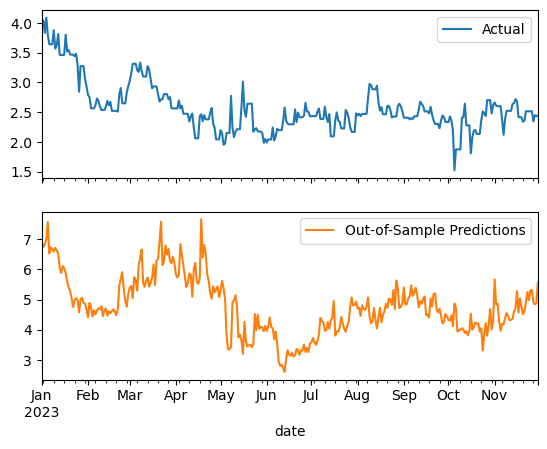

In [394]:
# Plot the out-of-sample results for 2023
out_of_sample_results6.plot(subplots=True)

In [395]:
# Evaluate the model
mse6 = mean_squared_error(y_test, predictions_lasso2)
print("Mean Squared Error:", mse6)

# R squared
r_squared6 = model_lasso2.score(X_test2_scaled, y_test)

print("R-squared for the model:", r_squared6)

Mean Squared Error: 5.5964633623178965
R-squared for the model: -30.922415447388094


In [396]:
# Extract the coefficients
lasso_coefficients2 = model_lasso2.coef_
lasso_coefficients2

array([ 0.72161936, -0.        , -0.26559222,  0.01182932,  0.21838144,
        0.        ,  0.26159867,  0.        ,  0.        ,  0.32180946,
       -0.        , -0.13368158, -0.26813824,  0.        , -0.12135927,
        0.15454985,  0.        ,  0.02286143,  0.        , -0.        ,
       -0.        , -0.        ,  0.        ])

In [397]:
# Convert coefficients lists to strings for display
lr_coefficients_str2 = ', '.join(map(str, lr_coefficients2))
ridge_coefficients_str2 = ', '.join(map(str, ridge_coefficients2))
lasso_coefficients_str2 = ', '.join(map(str, lasso_coefficients2))

# Create a DataFrame to display the comparison
comparison_df2 = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge', 'Lasso'],
    'MSE': [mse4, mse5, mse6],
    'R-Squared': [r_squared4, r_squared5, r_squared6],
    'Coefficients': [lr_coefficients_str2, ridge_coefficients_str2, lasso_coefficients_str2]
})

pd.set_option('display.max_colwidth', None)
comparison_df2

Model       MSE  R-Squared  \
0  Linear Regression  6.998613 -38.920327   
1              Ridge  4.269652 -23.354239   
2              Lasso  5.596463 -30.922415   

                                                                                                                                                                                                                                                                                                                                                                                  Coefficients  
0  [ 3.30614849e-01 -8.98044204e-01  5.88550645e-01  1.43328203e-01\n -4.46760515e-02 -9.39443825e-02  3.49183764e-05  3.52326662e-05\n -3.88953855e-05  4.86228947e-05 -1.03884858e-04 -1.22747149e-04\n -6.80513496e-05 -3.24249004e-05  6.25821223e-06  2.98096165e-05\n -2.74087757e-06  2.39729446e-02 -4.16338762e-03 -1.02013785e-02\n  6.15077868e-04  1.12923612e-03  2.98283154e-03]  
1                                                                                                  [ 0.33233652  0.02919962 -0.04180421  0.06912865  0.19906093  0.03675577\n  0.18911882  0.06032627  0.13877781  0.24071163 -0.01162798 -0.09078194\n -0.22340389  0.06041201 -0.14511583  0.15014984 -0.01891373  0.05176257\n  0.00203479 -0.01184291 -0.0105474  -0.00801837  0.03271415]  
2                                                                                     0.7216193580442067, -0.0, -0.26559221651990333, 0.011829322201656214, 0.21838143793645726, 0.0, 0.2615986666833296, 0.0, 0.0, 0.3218094552712344, -0.0, -0.13368158205396227, -0.2681382393016352, 0.0, -0.12135926803251113, 0.15454984703460398, 0.0, 0.022861428298283925, 0.0, -0.0, -0.0, -0.0, 0.0

In [398]:
comparison_df

Model       MSE  R-Squared  \
0  Linear Regression  0.142992   0.184369   
1              Ridge  0.132586   0.243728   
2              Lasso  0.136827   0.219536   

                                                                Coefficients  
0  [ 0.01231508 -0.00256354 -0.03728072  0.01411822 -0.04326349  0.01825188]  
1  [-0.00700735 -0.00745356 -0.00746668  0.00145189 -0.0003033   0.00660211]  
2                          -0.0023773185, -0.0, -0.015513029, 0.0, -0.0, 0.0

### ARMA Model

In [399]:
combined_df.head()

aeco_5a_cad/gj  electricity_daily_average  \
date                                                    
2018-01-01          3.3518                      37.12   
2018-01-02          2.0754                      33.27   
2018-01-03          1.8480                      34.03   
2018-01-04          1.8377                      32.83   
2018-01-05          1.5431                      32.65   

            electricity_daily_on_peak_average  \
date                                            
2018-01-01                              35.50   
2018-01-02                              33.89   
2018-01-03                              35.20   
2018-01-04                              34.77   
2018-01-05                              34.10   

            electricity_daily_off_peak_average  electricity_30ravg_average  \
date                                                                         
2018-01-01                               40.36                       22.62   
2018-01-02                               32.05                       22.96   
2018-01-03                               31.69                       23.44   
2018-01-04                               28.93                       23.95   
2018-01-05                               29.76                       24.38   

            electricity_30ravg_on_peak_average  \
date                                             
2018-01-01                               23.69   
2018-01-02                               24.03   
2018-01-03                               24.53   
2018-01-04                               25.09   
2018-01-05                               25.53   

            electricity_30ravg__off_peak_average  \
date                                               
2018-01-01                                 20.48   
2018-01-02                                 20.82   
2018-01-03                                 21.25   
2018-01-04                                 21.67   
2018-01-05                                 22.06   

            measured_receipts_volume_(103m3)  \
date                                           
2018-01-01                          409984.7   
2018-01-02                          417066.6   
2018-01-03                          397375.6   
2018-01-04                          410188.4   
2018-01-05                          398015.6   

            ngtl_storage_receipts_volume_(103m3)  \
date                                               
2018-01-01                               67055.7   
2018-01-02                               53334.3   
2018-01-03                               28213.0   
2018-01-04                               38279.6   
2018-01-05                               22488.2   

            ngtl_gordondale_receipts_volume_(103m3)  ...  \
date                                                 ...   
2018-01-01                                   4327.7  ...   
2018-01-02                                   5141.3  ...   
2018-01-03                                   4423.3  ...   
2018-01-04                                   4600.9  ...   
2018-01-05                                   4986.4  ...   

            ngtl_abc_deliveries_volume_(103m3)  \
date                                             
2018-01-01                             61914.5   
2018-01-02                             63916.3   
2018-01-03                             64814.9   
2018-01-04                             65416.2   
2018-01-05                             62671.0   

            ngtl_mcneil_deliveries_volume_(103m3)  \
date                                                
2018-01-01                                47056.8   
2018-01-02                                46709.1   
2018-01-03                                46160.5   
2018-01-04                                43285.0   
2018-01-05                                45130.2   

            ngtl_gordondale_deliveries_volume_(103m3)  \
date                                                    
2018-01-01                                   

In [455]:
temp_df = combined_df[['temperature_2m_mean']]
temp_df.tail()

temperature_2m_mean
date                           
2023-11-26            -1.780167
2023-11-27            -0.090583
2023-11-28             0.757333
2023-11-29            -1.486417
2023-11-30            -4.055167

In [425]:
temp_df_old = temp_df[temp_df.index <= '2022-12-31']

In [407]:
from statsmodels.tsa.stattools import adfuller

In [408]:
def dickey_fuller(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value:        %f ' % result[1])
    print('Lags used:      %d' % result[2])
    print('Critical Values:')
    for key, value in result[4].items():
        print('%s: %.3f' % (key, value))
    if result[1]<0.05:
        print('\The p-value is below the significance level of 0.05. \n\nWe can reject the hypothesis that the time series is non-stationary.')
    else: 
        print('\The p-value is above the significance level of 0.05. \n\nWe cannot reject the hypothesis that the time series is non-stationary.')
 

In [430]:
dickey_fuller(temp_df_old)

ADF Statistic: -3.680868
p-value:        0.004390 
Lags used:      10
Critical Values:
1%: -3.434
5%: -2.863
10%: -2.568
\The p-value is below the significance level of 0.05. 

We can reject the hypothesis that the time series is non-stationary.


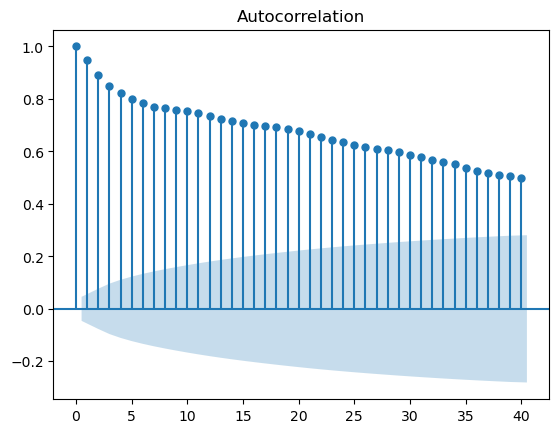

In [431]:
# Plot the autocorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(temp_df_old, lags=40)
plt.show()

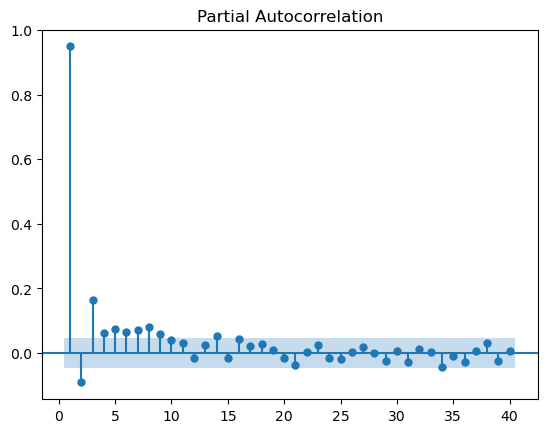

In [432]:
# Plot the partial autocorrelation
plot_pacf(temp_df_old, zero=False, lags=40)
plt.show()

In [417]:
from statsmodels.tsa.arima_model import ARMA

In [461]:
model_arma = ARMA(temp_df_old.temperature_2m_mean, order=(3, 3))
result = model_arma.fit()
result.summary()

C:\Users\zhaoy\anaconda3\envs\tf2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\zhaoy\anaconda3\envs\tf2\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\zhaoy\anaconda3\envs\tf2\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\zhaoy\anaconda3\envs\tf2\lib\site-packages\statsmodels\tsa\arima_model.py:1521: RuntimeWarning:

invalid value encountered in sqrt



<class 'statsmodels.iolib.summary.Summary'>
"""
                               ARMA Model Results                              
===============================================================================
Dep. Variable:     temperature_2m_mean   No. Observations:                 1826
Model:                      ARMA(3, 3)   Log Likelihood               -4815.575
Method:                        css-mle   S.D. of innovations              3.379
Date:                 Mon, 26 Feb 2024   AIC                           9647.151
Time:                         16:21:28   BIC                           9691.230
Sample:                     01-01-2018   HQIC                          9663.410
                          - 12-31-2022                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         3.3304      2.221      1.499      0.134      -1.023       7.684
ar.L1.temperature_2m_mean     2.6137        nan        nan        nan         nan         nan
ar.L2.temperature_2m_mean    -2.2395      0.006   -390.594      0.000      -2.251      -2.228
ar.L3.temperature_2m_mean     0.6256      0.003    226.649      0.000       0.620       0.631
ma.L1.temperature_2m_mean    -1.5927      0.022    -73.453      0.000      -1.635      -1.550
ma.L2.temperature_2m_mean     0.3370      0.043      7.849      0.000       0.253       0.421
ma.L3.temperature_2m_mean     0.2612      0.022     11.931      0.000       0.218       0.304
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0163           -0.0176j            1.0165           -0.0027
AR.2            1.0163           +0.0176j            1.0165            0.0027
AR.3            1.5470           -0.0000j            1.5470           -0.0000
MA.1            1.0591           -0.0367j            1.0598           -0.0055
MA.2            1.0591           +0.0367j            1.0598            0.0055
MA.3           -3.4086           -0.0000j            3.4086           -0.5000
-----------------------------------------------------------------------------
"""

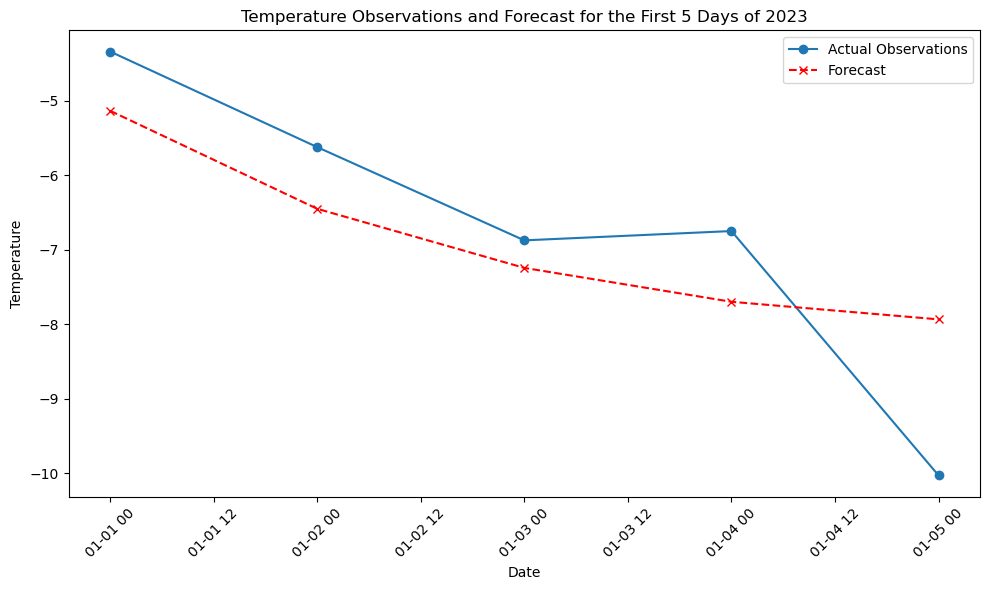

In [462]:
forecast_values = result.forecast(steps=5)[0]
forecast_dates = pd.date_range(start='2023-01-01', periods=5)

# Convert forecast values to a DataFrame for easier plotting
forecast_df = pd.DataFrame(forecast_values, index=forecast_dates, columns=['Forecast'])

# Filter the DataFrame to include only the first 5 days of 2023
first_5_days_2023 = temp_df['2023-01-01':'2023-01-05']

# Plotting
plt.figure(figsize=(10, 6)) 

# Plot actual observations
plt.plot(first_5_days_2023.index, first_5_days_2023['temperature_2m_mean'], marker='o', label='Actual Observations')

# Plot forecasted values
plt.plot(forecast_df.index, forecast_df['Forecast'], marker='x', linestyle='--', color='red', label='Forecast')

plt.title('Temperature Observations and Forecast for the First 5 Days of 2023')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout() 
plt.show()


In [456]:
# Count the number of observations in the remaining dataset
observations_count = temp_df['2023-01-01':'2023-11-30'].shape[0]
observations_count

334

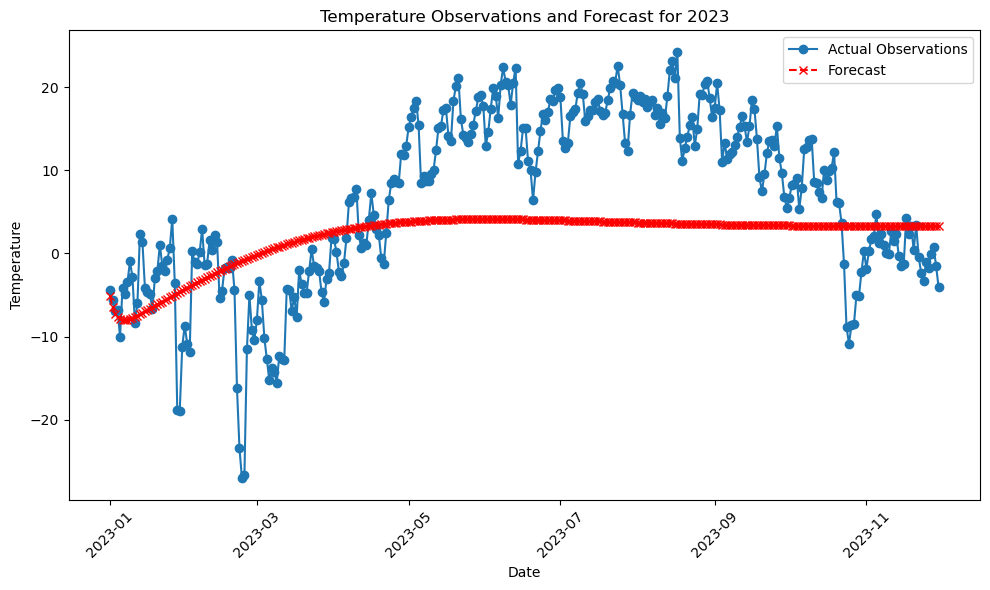

In [463]:
forecast_values = result.forecast(steps=observations_count)[0]
forecast_dates = pd.date_range(start='2023-01-01', periods=observations_count)

# Convert forecast values to a DataFrame for easier plotting
forecast_df = pd.DataFrame(forecast_values, index=forecast_dates, columns=['Forecast'])

# Filter the DataFrame to include only the first 5 days of 2023
all_2023_days = temp_df['2023-01-01':'2023-11-30']

# Plotting
plt.figure(figsize=(10, 6)) 

# Plot actual observations
plt.plot(all_2023_days.index, all_2023_days['temperature_2m_mean'], marker='o', label='Actual Observations')

# Plot forecasted values
plt.plot(forecast_df.index, forecast_df['Forecast'], marker='x', linestyle='--', color='red', label='Forecast')

plt.title('Temperature Observations and Forecast for 2023')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout() 
plt.show()

In [460]:
import itertools
p = q = range(0, 4)
pq = itertools.product(p, q)
for param in pq:
    try:
        mod = ARMA(temp_df_old.temperature_2m_mean,order=param)
        results = mod.fit()
        print('ARMA{} - AIC:{}'.format(param, results.aic))
    except:
        continue

C:\Users\zhaoy\anaconda3\envs\tf2\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


C:\Users\zhaoy\anaconda3\envs\tf2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\zhaoy\anacond

ARMA(0, 0) - AIC:13995.794084638663
ARMA(0, 1) - AIC:12112.905102918321
ARMA(0, 2) - AIC:11140.467590462133
ARMA(0, 3) - AIC:10667.158802068636
ARMA(1, 0) - AIC:9774.875576023229
ARMA(1, 1) - AIC:9748.574648883452


C:\Users\zhaoy\anaconda3\envs\tf2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\zhaoy\anaconda3\envs\tf2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\zhaoy\anaconda3\envs\tf2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARMA(1, 2) - AIC:9710.52104199259


C:\Users\zhaoy\anaconda3\envs\tf2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARMA(1, 3) - AIC:9684.36075259509
ARMA(2, 0) - AIC:9757.508620820008


C:\Users\zhaoy\anaconda3\envs\tf2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\zhaoy\anaconda3\envs\tf2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARMA(2, 1) - AIC:9735.074310345963


C:\Users\zhaoy\anaconda3\envs\tf2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARMA(2, 2) - AIC:9652.031686334947


C:\Users\zhaoy\anaconda3\envs\tf2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARMA(2, 3) - AIC:9654.023017541029
ARMA(3, 0) - AIC:9707.852204963092


C:\Users\zhaoy\anaconda3\envs\tf2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\zhaoy\anaconda3\envs\tf2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARMA(3, 1) - AIC:9657.62221305556


C:\Users\zhaoy\anaconda3\envs\tf2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARMA(3, 2) - AIC:9654.022025048216


C:\Users\zhaoy\anaconda3\envs\tf2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARMA(3, 3) - AIC:9647.150682488791


C:\Users\zhaoy\anaconda3\envs\tf2\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\zhaoy\anaconda3\envs\tf2\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



### ARIMA for Price Prediction

In [105]:
# Transform into a stationary process
price_variables_copy['aeco_return'] = price_variables_copy['aeco_5a_cad/gj'].pct_change()
price_variables_copy.head()

henry_usd/mmbtu  aeco_5a_usd/mmbtu  aeco_5a_cad/gj  \
date                                                             
2018-01-01            3.580             2.8248          3.3518   
2018-01-02            3.580             1.7509          2.0754   
2018-01-03            6.625             1.5555          1.8480   
2018-01-04            6.875             1.5478          1.8377   
2018-01-05            4.420             1.3134          1.5431   

            electricity_daily_average  electricity_daily_on_peak_average  \
date                                                                       
2018-01-01                      37.12                              35.50   
2018-01-02                      33.27                              33.89   
2018-01-03                      34.03                              35.20   
2018-01-04                      32.83                              34.77   
2018-01-05                      32.65                              34.10   

            electricity_daily_off_peak_average  electricity_30ravg_average  \
date                                                                         
2018-01-01                               40.36                       22.62   
2018-01-02                               32.05                       22.96   
2018-01-03                               31.69                       23.44   
2018-01-04                               28.93                       23.95   
2018-01-05                               29.76                       24.38   

            electricity_30ravg_on_peak_average  \
date                                             
2018-01-01                               23.69   
2018-01-02                               24.03   
2018-01-03                               24.53   
2018-01-04                               25.09   
2018-01-05                               25.53   

            electricity_30ravg__off_peak_average  \
date                                               
2018-01-01                                 20.48   
2018-01-02                                 20.82   
2018-01-03                                 21.25   
2018-01-04                                 21.67   
2018-01-05                                 22.06   

            measured_receipts_volume_(103m3)  ...  \
date                                          ...   
2018-01-01                          409984.7  ...   
2018-01-02                          417066.6  ...   
2018-01-03                          397375.6  ...   
2018-01-04                          410188.4  ...   
2018-01-05                          398015.6  ...   

            ngtl_gordondale_receipts_volume_(103m3)  \
date                                                  
2018-01-01                                   4327.7   
2018-01-02                                   5141.3   
2018-01-03                                   4423.3   
2018-01-04                                   4600.9   
2018-01-05                                   4986.4   

            ngtl_groundbirch_east_receipts_volume_(103m3)  \
date                                                        
2018-01-01                                        12802.6   
2018-01-02                                        12527.0   
2018-01-03                                        11005.8   
2018-01-04                                        12507.9   
2018-01-05                                        13869.0   

            ngtl_intra_provincial_deliveries_volume_(103m3)  \
date                                                          
2018-01-01                                         189057.3   
2018-01-02                                         186041.2   
2018-01-03                                         185875.1   
2018-01-04                                         186013.1   
2018-01-05                                         180811.1   

            ngtl_border_deliveries_volume_(103m3)  \
date                                                
2018-01-01         

In [116]:
price_variables_copy2 = price_variables_copy.dropna()
# Select only the returns
aeco_returns = price_variables_copy2.loc[:, 'aeco_return']

<AxesSubplot:xlabel='date'>

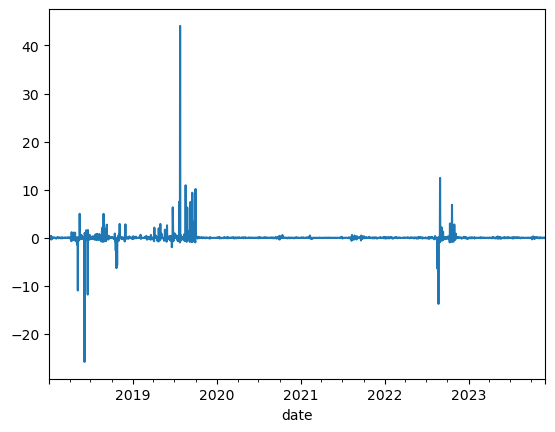

In [117]:
aeco_returns.plot()

In [108]:
# Import the ARMA model
from statsmodels.tsa.arima_model import ARMA

In [118]:
# Create the ARMA model using the return values and the order
# For the order parameter, the first 1 indicates the number of AR lags
# For the order parameter, the second 1 indicates the number of MA lags
model1 = ARMA(aeco_returns.values, order=(1,1))
# Fit the model to the data
results1 = model1.fit()
type(results1)

C:\Users\zhaoy\anaconda3\envs\tf2\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)




statsmodels.tsa.arima_model.ARMAResultsWrapper

In [120]:
#The result of the forecast() function is an array containing the forecast value, the standard error of the forecast, and the confidence interval information. 
print(f'forecast {results1.forecast()}')
print(f'Standard Error {results1.forecast()[1]}')
print(f'Confidence Interval {results1.forecast()[2]}')

forecast (array([0.03735924]), array([1.38266411]), array([[-2.67261262,  2.7473311 ]]))
Standard Error [1.38266411]
Confidence Interval [[-2.67261262  2.7473311 ]]


<AxesSubplot:title={'center':'Aeco Return Forecast'}>

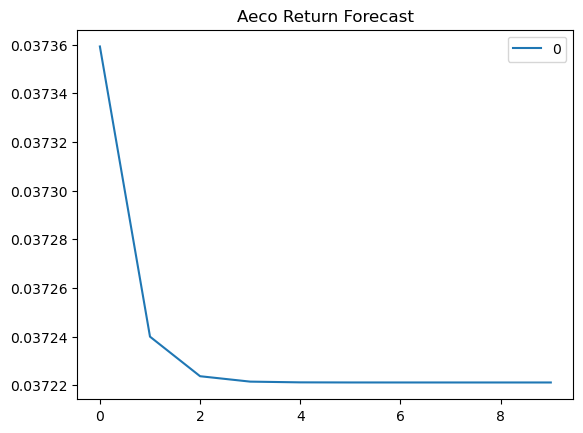

In [121]:
# Plot the forecasted return for the next 10 days
pd.DataFrame(results1.forecast(steps=10)[0]).plot(title="Aeco Return Forecast")

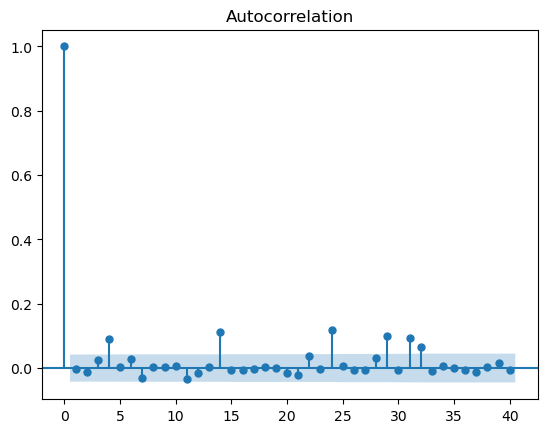

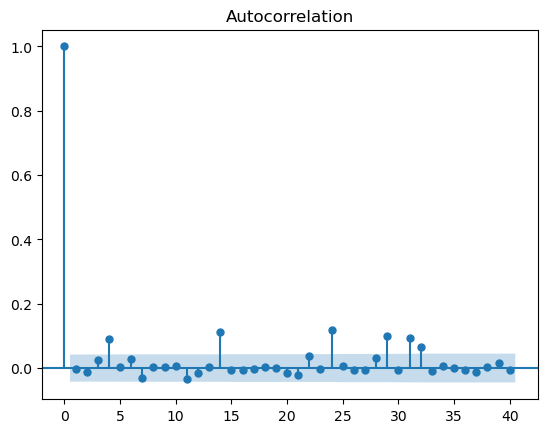

In [126]:
# Plot the autocorrelation of the aeco data
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(aeco_returns, lags=40)

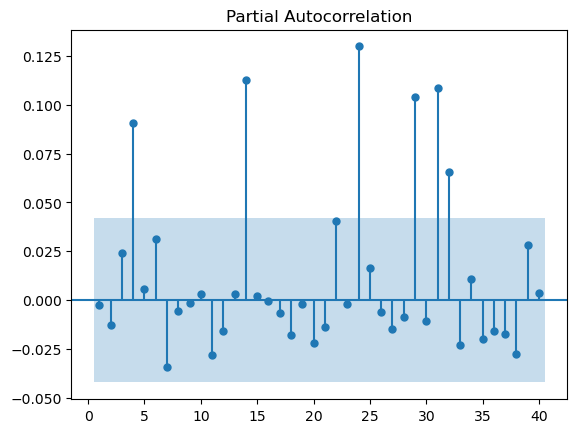

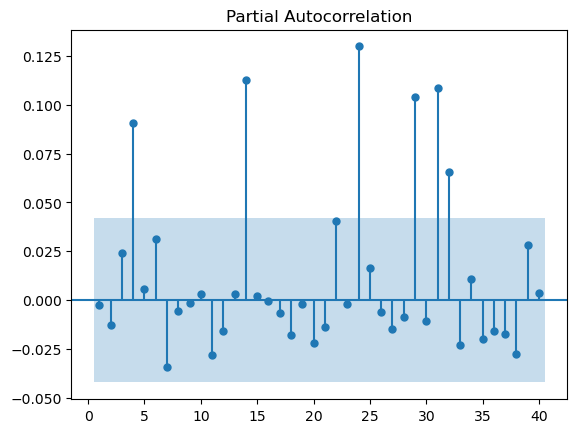

In [127]:
# Plot the partial autocorrelation of the aeco data
plot_pacf(aeco_returns, zero=False, lags=40)